# Model: Predicting Likelihood of Flooding by Zip Code

## Summary

In this notebook, I will be determining the likelihood for flooding to occur by zip code, in light of the flood damage impacts from Hurricane Harvey. I feature engineered a column to determine general likelihood based on the number of claims that FEMA received in each zip code and whether or not each claim was confirmed to have flood damage. That information is then fed back into a model made to enhance the expectation that a zip code is likely to flood using a binary regression.

## Import

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import copy

pd.set_option('display.max_columns', None) # Displays all columns

from scipy.stats import kurtosis, skew

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
def view(dataframe, n: int=3):
    """Displays the preview of the first and last rows of the dataframe
    Args:
        dataframe: The dataframe being called
        n: Number of rows to select for preview. Defaults to 3.
    Returns:
        The first n and the last n rows of the dataframe
    """

    with pd.option_context('display.max_rows',n*2):
        display(dataframe)

In [3]:
def rename(dataframe, column, original, rename):
    """Replaces all instances of a specific string in one column with a new string
    Args:
        dataframe: The dataframe being called
        column: The column being called
        oringal: Original string to be replaced
        rename: New string to replace original string
    """

    dataframe.loc[dataframe[column].str.contains(original), column] = str(rename)
    return

In [4]:
def stats(dataframe, column):
    """Generates single column stats and boxplot
    Args:
        dataframe: The dataframe being called
        column: The column being called
    Returns:
        Descriptive statistics and boxplot of the column
    """
    
    print(f'Data type: {dataframe[column].dtype}')
    print(f'Count: {dataframe[column].shape[0]}')
    print(f'Number of Unique Values: {dataframe[column].nunique()}')
    print(f'Number of nulls: {dataframe[column].isna().sum()} - {round(100*dataframe[column].isna().sum()/len(dataframe),2)}%')
    print()
    print(f'Mean: {dataframe[column].mean()}')
    print(f'Minimum: {dataframe[column].min()}')
    print(f'Lower Quartile: {dataframe[column].quantile(.25)}')
    print(f'Median: {dataframe[column].quantile(.5)}')
    print(f'Upper Quartile: {dataframe[column].quantile(.75)}')
    print(f'Maximum: {dataframe[column].max()}')

    plt.figure(figsize=(10,1))
    plt.title(f'Boxplot Distrubution of {column}', fontsize=14, fontweight='bold')
    ax = sns.boxplot(x=dataframe[column])
    plt.xlabel(column, fontsize=13, fontweight='bold')
    plt.show()

In [5]:
def preview_cols(dataframe):
    """Generates quick preview of each column in the dataframe
    Args:
        dataframe: The dataframe being called
    Returns:
        Datatype
        Number of unique values
        Number of nulls
        Descriptive statistics and boxplot for numeric columns
        The first n and the last n values of the column
        Visualization of most frequent values
        
    """
    
    for i in dataframe.columns:
        print(i.upper())
        print()
        if (dataframe[i].dtype=='int' or dataframe[i].dtype=='float'): 
            print(stats(dataframe,i))
        else: 
            print(f'Data type: {dataframe[i].dtype}')
            print(f'Number of unique values: {dataframe[i].nunique()}')
            print(f'Number of nulls: {dataframe[i].isna().sum()} - {round(100*dataframe[i].isna().sum()/len(dataframe),2)}%')
            print (dataframe[i].describe())
        print()
        print(view(dataframe[~dataframe[i].isna()][i].astype('str').value_counts().sort_index()))
        print()
        dataframe[i].value_counts().head(20).plot(kind='barh', figsize=(8,6))
        plt.title(f'Most common values in the {i} column', fontsize=14, fontweight='bold')
        plt.ylabel('Value', fontsize=13, fontweight='bold')
        plt.xlabel('Frequency of Occurence', fontsize=13, fontweight='bold')
        plt.show()
        print()
        print('*'*50)
        print()

## Merged DataFrame: Load and Preview

In [6]:
df = pd.read_csv('fema_mls_merged.csv', index_col=0)

In [7]:
view(df,3)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
0,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
1,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
2,77489,5,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
...,...,...,...,...,...,...,...,...,...,...,...,...
180068,78944,1,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180069,78944,3,True,False,False,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180070,78944,2,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000


### Info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180071 entries, 0 to 180070
Data columns (total 12 columns):
zip_code               180071 non-null int64
house_occupants        180071 non-null int64
homeownersinsurance    180071 non-null bool
floodinsurance         180071 non-null bool
flooddamage            180071 non-null bool
list_price             180071 non-null float64
sq_ft_total            180071 non-null float64
bedrooms               180071 non-null float64
baths_full             180071 non-null float64
baths_half             180071 non-null float64
stories                180071 non-null float64
home_age               180071 non-null float64
dtypes: bool(3), float64(7), int64(2)
memory usage: 14.3 MB


### Describe

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zip_code,180071.0,77273.130921,221.284866,77002.000000,77053.000000,77336.000000,77502.000000,78950.000000
house_occupants,180071.0,2.864037,1.702879,1.000000,1.000000,2.000000,4.000000,22.000000
list_price,180071.0,244646.235429,101161.284603,65975.000000,171265.761968,217999.581940,306716.976440,646146.891278
sq_ft_total,180071.0,2146.141255,470.298654,972.000000,1760.281553,2097.409767,2543.941940,3367.054759
bedrooms,180071.0,3.404141,0.315062,1.000000,3.143478,3.411069,3.673214,4.000000
baths_full,180071.0,2.125974,0.317861,1.000000,1.933665,2.113752,2.402930,3.058067
baths_half,180071.0,0.458969,0.172199,0.000000,0.329787,0.465698,0.577966,0.876500
stories,180071.0,1.438814,0.250414,1.000000,1.256522,1.457470,1.593682,2.690476
home_age,180071.0,29.712464,13.591341,4.705882,19.028050,27.872059,41.397849,67.173077


## Preparing the Data for Modeling

### Multicollinearity Heat Map

The heat map reveals information regarding the relationship between the different features. A high value (indicated by a value that's close to either -1 or 1) can indicate concern, as that means that the features involved might influence each other and give inaccurate information regarding their predictive ability for the target.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180071 entries, 0 to 180070
Data columns (total 12 columns):
zip_code               180071 non-null int64
house_occupants        180071 non-null int64
homeownersinsurance    180071 non-null bool
floodinsurance         180071 non-null bool
flooddamage            180071 non-null bool
list_price             180071 non-null float64
sq_ft_total            180071 non-null float64
bedrooms               180071 non-null float64
baths_full             180071 non-null float64
baths_half             180071 non-null float64
stories                180071 non-null float64
home_age               180071 non-null float64
dtypes: bool(3), float64(7), int64(2)
memory usage: 14.3 MB


In [11]:
df.zip_code = df.zip_code.astype('str')

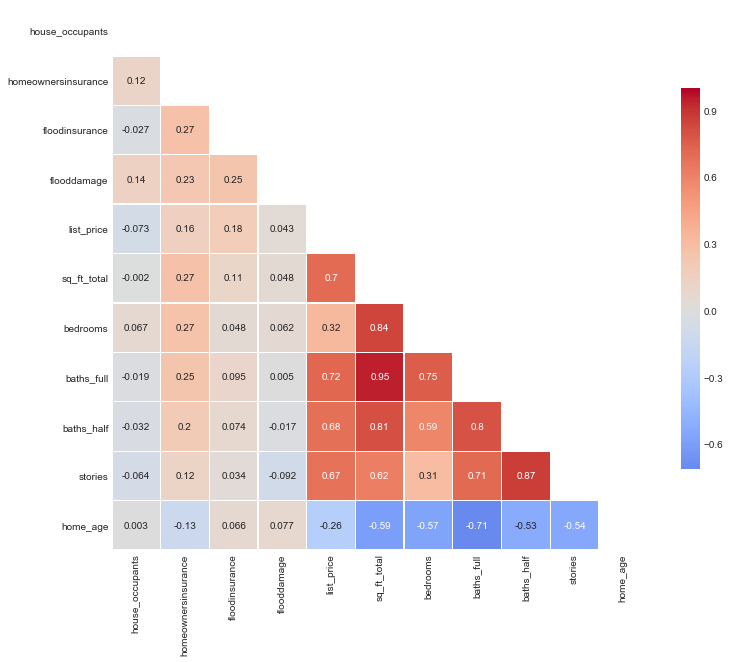

In [12]:
f, ax = plt.subplots(figsize=(12,10))

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(df.corr(),3), mask=mask, cbar_kws={'shrink':.7}, annot=True, center=0, linewidth=0.3, cmap='coolwarm');

In [13]:
df.drop(columns=['sq_ft_total','baths_full','baths_half'], inplace=True)

In [14]:
# df.drop(columns=['list_price'], inplace=True)

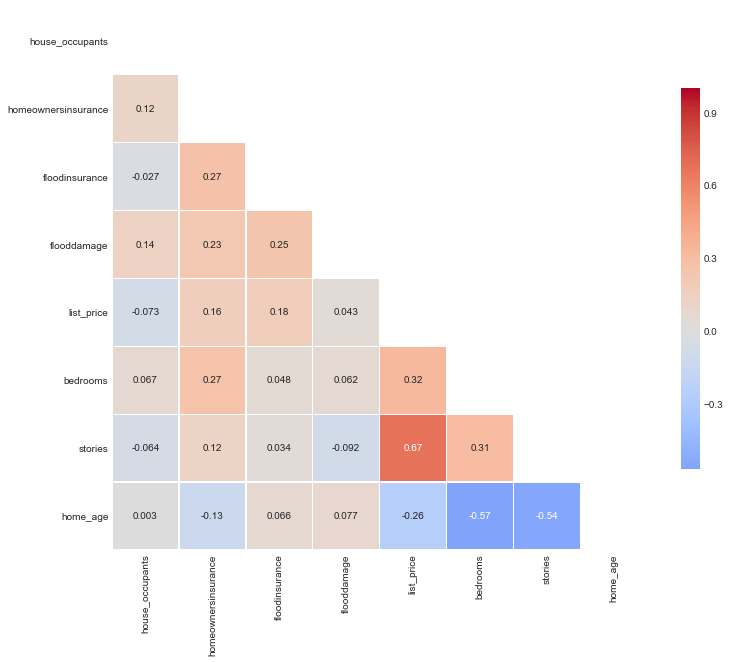

In [15]:
f, ax = plt.subplots(figsize=(12,10))

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(df.corr(),3), mask=mask, cbar_kws={'shrink':.7}, annot=True, center=0, linewidth=0.3, cmap='coolwarm');

In [16]:
view(df,3)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,bedrooms,stories,home_age
0,77489,2,True,False,False,160808.871552,3.427108,1.427502,29.936958
1,77489,2,True,False,False,160808.871552,3.427108,1.427502,29.936958
2,77489,5,True,False,False,160808.871552,3.427108,1.427502,29.936958
...,...,...,...,...,...,...,...,...,...
180068,78944,1,True,False,True,149389.000000,4.000000,1.500000,30.000000
180069,78944,3,True,False,False,149389.000000,4.000000,1.500000,30.000000
180070,78944,2,True,False,True,149389.000000,4.000000,1.500000,30.000000


In [17]:
list(df.columns)

['zip_code',
 'house_occupants',
 'homeownersinsurance',
 'floodinsurance',
 'flooddamage',
 'list_price',
 'bedrooms',
 'stories',
 'home_age']

### Standard Scaler

The continuous features need to be scaled to the same scale to analyze them without distorted weighting, as the scales for each may differ. Standard Scaler transforms the data in each feature to have a mean of 0 and a standard deviation of 1.

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [19]:
df_scale = df.copy(deep=True)

In [20]:
df_scale.describe().columns[4:]

Index(['home_age'], dtype='object')

In [21]:
numeric_cols = df_scale.describe().columns[4:]

In [22]:
df_scale[numeric_cols] = sc.fit_transform(df_scale[numeric_cols])

In [23]:
df_scale[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
home_age,180071.0,-2.272840e-16,1.000003,-1.839896,-0.786121,-0.135411,0.859769,2.756219


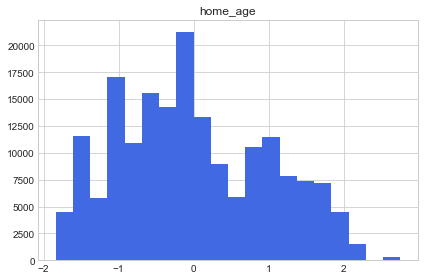

In [24]:
# Histograms

df_scale[numeric_cols].hist(bins=20, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

In [25]:
for each in list(numeric_cols):
    print('For '+str(each)+' the skew is '+str(round(skew(df_scale[each]),3))+' and the kurtosis is '+str(round(kurtosis(df_scale[each]),3)))

For home_age the skew is 0.31 and the kurtosis is -0.816


### Log Transform

Regression tasks only work with data that is close to normal, for accurate predictive value. The two continuous variables are slightly skewed. I will perform a log transformation to see if it helps normalize the data.

In [26]:
df_log = df_scale.copy(deep=True)

In [27]:
for c in [numeric_cols]:
    df_log[c] = np.log(df_log[c]+5)

In [28]:
len(df)

180071

In [29]:
df_log.isna().any()

zip_code               False
house_occupants        False
homeownersinsurance    False
floodinsurance         False
flooddamage            False
list_price             False
bedrooms               False
stories                False
home_age               False
dtype: bool

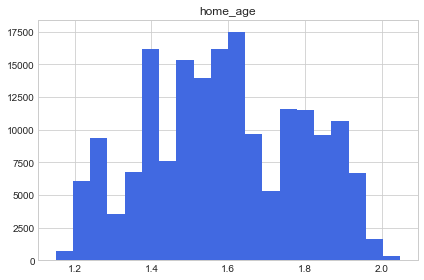

In [30]:
df_log[numeric_cols].hist(bins=20, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

In [31]:
for each in list(numeric_cols):
    print('For '+str(each)+' the skew is '+str(round(skew(df_log[each]),3))+' and the kurtosis is '+str(round(kurtosis(df_log[each]),3)))

For home_age the skew is -0.021 and the kurtosis is -0.868


In [32]:
df_log.describe().T

,count,mean,std,min,25%,50%,75%,max
house_occupants,180071.0,2.864037,1.702879,1.000000,1.000000,2.000000,4.000000,22.000000
list_price,180071.0,244646.235429,101161.284603,65975.000000,171265.761968,217999.581940,306716.976440,646146.891278
bedrooms,180071.0,3.404141,0.315062,1.000000,3.143478,3.411069,3.673214,4.000000
stories,180071.0,1.438814,0.250414,1.000000,1.256522,1.457470,1.593682,2.690476
home_age,180071.0,1.589427,0.200488,1.150605,1.438384,1.581982,1.768110,2.048495


The log-transformed version looks more normal, so I will use that one for modeling.

In [33]:
df_use = df_log.copy(deep=True)

### Binning Zip Codes

To avoid overfitting in my model, I will bin the zip codes. I created 20 different bins and grouped the zip codes by county further broken up into county divisions.

In [34]:
df_use['county'] = pd.Series()

In [35]:
Austin_County = ['77418', '77426', '77474', '77485', '77833', '78931', '78933', '78940', '78944', '78950', '78954']
Brazoria_County_N = ['77047', '77430', '77511', '77531', '77546', '77578', '77581', '77583', '77584']
Brazoria_County_S = ['77422', '77444', '77480', '77486', '77515', '77534', '77541', '77566', '77577']
Chambers_County = ['77514', '77520', '77521', '77523', '77560', '77597', '77622', '77665']
Fort_Bend_County_N = ['77082', '77083', '77099', '77406', '77407', '77417', '77435', '77441', '77450', '77471', '77498']
Fort_Bend_County_S = ['77053', '77085', '77420', '77459', '77461', '77469', '77478', '77479', '77489', '77545']
Galveston_County = ['77510', '77517', '77518', '77539', '77550', '77551', '77554', '77563', '77565', '77568', '77573', '77590', '77591']
Harris_Inner_North = ['77003', '77004', '77005', '77006', '77007', '77008', '77009', '77019', '77027', '77046', '77098', '77401']
Harris_Inner_South = ['77002', '77010', '77011', '77012', '77020', '77021', '77023', '77025', '77026', '77030', '77054', '77201']
Harris_NE = ['77013', '77015', '77016', '77022', '77028', '77037', '77039', '77049', '77050', '77060', '77073', '77076', '77078', '77093']
Harris_North = ['77018', '77038', '77088', '77091', '77338', '77345', '77346', '77396', '77336', '77532', '77044', '77530', '77562', '77032', '77315']
Harris_North_Suburbs = ['77041', '77065', '77373', '77375', '77377', '77379', '77388', '77389', '77429', '77433', '77068', '77069', '77449']
Harris_NW = ['77014', '77040', '77043', '77055', '77064', '77066', '77067', '77070', '77080', '77084', '77086', '77090', '77092', '77095']
Harris_SE_Suburbs = ['77536', '77547', '77502', '77503', '77504', '77505', '77506', '77507', '77571', '77586', '77587', '77598', '77058', '77059']
Harris_South = ['77017', '77029', '77033', '77034', '77035', '77045', '77048', '77051', '77061', '77062', '77071', '77075', '77087', '77089']
Harris_SW = ['77024', '77031', '77036', '77042', '77056', '77057', '77063', '77072', '77074', '77077', '77079', '77081', '77094', '77096']
Libery_County = ['77327', '77328', '77357', '77371', '77372', '77535', '77538', '77564', '77575']
Montgomery_County_E = ['77301', '77302', '77303', '77306', '77318', '77339', '77358', '77365', '77378', '77385', '77386']
Montgomery_County_W = ['77304', '77316', '77354', '77356', '77362', '77380', '77381', '77382', '77384', '77447', '77873']
Waller_County = ['77355', '77363', '77423', '77445', '77447', '77484', '77493', '77494']

In [36]:
df_use.loc[df_use.zip_code.isin(Austin_County), 'county'] = 'Austin_County'
df_use.loc[df_use.zip_code.isin(Brazoria_County_N), 'county'] = 'Brazoria_County_N'
df_use.loc[df_use.zip_code.isin(Brazoria_County_S), 'county'] = 'Brazoria_County_S'
df_use.loc[df_use.zip_code.isin(Chambers_County), 'county'] = 'Chambers_County'
df_use.loc[df_use.zip_code.isin(Fort_Bend_County_N), 'county'] = 'Fort_Bend_County_N'
df_use.loc[df_use.zip_code.isin(Fort_Bend_County_S), 'county'] = 'Fort_Bend_County_S'
df_use.loc[df_use.zip_code.isin(Galveston_County), 'county'] = 'Galveston_County'
df_use.loc[df_use.zip_code.isin(Harris_Inner_North), 'county'] = 'Harris_Inner_North'
df_use.loc[df_use.zip_code.isin(Harris_Inner_South), 'county'] = 'Harris_Inner_South'
df_use.loc[df_use.zip_code.isin(Harris_NE), 'county'] = 'Harris_NE'
df_use.loc[df_use.zip_code.isin(Harris_North), 'county'] = 'Harris_North'
df_use.loc[df_use.zip_code.isin(Harris_North_Suburbs), 'county'] = 'Harris_North_Suburbs'
df_use.loc[df_use.zip_code.isin(Harris_NW), 'county'] = 'Harris_NW'
df_use.loc[df_use.zip_code.isin(Harris_SE_Suburbs), 'county'] = 'Harris_SE_Suburbs'
df_use.loc[df_use.zip_code.isin(Harris_South), 'county'] = 'Harris_South'
df_use.loc[df_use.zip_code.isin(Harris_SW), 'county'] = 'Harris_SW'
df_use.loc[df_use.zip_code.isin(Libery_County), 'county'] = 'Libery_County'
df_use.loc[df_use.zip_code.isin(Montgomery_County_E), 'county'] = 'Montgomery_County_E'
df_use.loc[df_use.zip_code.isin(Montgomery_County_W), 'county'] = 'Montgomery_County_W'
df_use.loc[df_use.zip_code.isin(Waller_County), 'county'] = 'Waller_County'

In [37]:
view(df_use,5)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,bedrooms,stories,home_age,county
0,77489,2,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
1,77489,2,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
2,77489,5,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
3,77489,1,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
4,77489,5,False,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
...,...,...,...,...,...,...,...,...,...,...
180066,77010,1,False,False,False,439900.000000,1.000000,1.000000,1.711307,Harris_Inner_South
180067,78944,3,True,False,True,149389.000000,4.000000,1.500000,1.613660,Austin_County
180068,78944,1,True,False,True,149389.000000,4.000000,1.500000,1.613660,Austin_County
180069,78944,3,True,False,False,149389.000000,4.000000,1.500000,1.613660,Austin_County


In [38]:
zipcodes = df_use.zip_code

In [39]:
df_use.drop(columns='zip_code', inplace=True)

### One Hot Encoding

Categorical data must be transformed to numeric data for modeling. To do that, I will use one hot encoding, which breaks the options for each feature into individual columns, detailing whether or not the entry for that line contains each feature option.

In [40]:
view(df_use,3)

,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,bedrooms,stories,home_age,county
0,2,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
1,2,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
2,5,True,False,False,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
...,...,...,...,...,...,...,...,...,...
180068,1,True,False,True,149389.000000,4.000000,1.500000,1.613660,Austin_County
180069,3,True,False,False,149389.000000,4.000000,1.500000,1.613660,Austin_County
180070,2,True,False,True,149389.000000,4.000000,1.500000,1.613660,Austin_County


In [41]:
for i in df_use.columns:
    if df_use[i].dtype=='bool':
        df_use[i] = df_use[i].astype('int')

In [42]:
view(df_use,3)

,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,bedrooms,stories,home_age,county
0,2,1,0,0,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
1,2,1,0,0,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
2,5,1,0,0,160808.871552,3.427108,1.427502,1.612736,Fort_Bend_County_S
...,...,...,...,...,...,...,...,...,...
180068,1,1,0,1,149389.000000,4.000000,1.500000,1.613660,Austin_County
180069,3,1,0,0,149389.000000,4.000000,1.500000,1.613660,Austin_County
180070,2,1,0,1,149389.000000,4.000000,1.500000,1.613660,Austin_County


In [43]:
X = df_use.drop(columns=['flooddamage']) # Features
y = df_use['flooddamage'] # Target

In [44]:
# Get dummies

X = pd.get_dummies(X, drop_first=True)

In [45]:
# Preview one hot encoded features

view(X,2)

,house_occupants,homeownersinsurance,floodinsurance,list_price,bedrooms,stories,home_age,county_Brazoria_County_N,county_Brazoria_County_S,county_Chambers_County,county_Fort_Bend_County_N,county_Fort_Bend_County_S,county_Galveston_County,county_Harris_Inner_North,county_Harris_Inner_South,county_Harris_NE,county_Harris_NW,county_Harris_North,county_Harris_North_Suburbs,county_Harris_SE_Suburbs,county_Harris_SW,county_Harris_South,county_Libery_County,county_Montgomery_County_E,county_Montgomery_County_W,county_Waller_County
0,2,1,0,160808.871552,3.427108,1.427502,1.612736,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,160808.871552,3.427108,1.427502,1.612736,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180069,3,1,0,149389.000000,4.000000,1.500000,1.613660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180070,2,1,0,149389.000000,4.000000,1.500000,1.613660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### _Export in case kernel needs to restart_

In [46]:
# Saving the cleaned features set
# X.to_csv('features.csv')

# Saving the cleaned target variable
# y.to_csv('target.txt')

### Importing Packages for Modeling

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV
import itertools

In [48]:
# Defining a function to plot a confusion matrix

def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

### Train-Test Split

In [49]:
# Separating the data into a training and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(f"Training set has {X_train.shape[0]} samples")
print(f"Testing set has {X_test.shape[0]} samples")

Training set has 144056 samples
Testing set has 36015 samples


## Modeling

### Vanilla Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
# Instantiate the logistic regression

logreg = LogisticRegression()

In [52]:
# Fit the model

logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
# Predictions
train_preds_logreg = logreg.predict(X_train)
test_preds_logreg = logreg.predict(X_test)

# Logistic regression scores
train_accuracy_logreg = accuracy_score(y_train, train_preds_logreg)
test_accuracy_logreg = accuracy_score(y_test, test_preds_logreg)
report_logreg = classification_report(y_test, test_preds_logreg)

# Print scores
print("Logistic Regression")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_logreg * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_logreg * 100):.4}%")
print()
print("\nClassification report:")
print(report_logreg)
print()

Logistic Regression
-------------------------
Training Accuracy: 50.89%
Test Accuracy:     50.13%


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     17960
           1       0.50      1.00      0.67     18055

    accuracy                           0.50     36015
   macro avg       0.25      0.50      0.33     36015
weighted avg       0.25      0.50      0.33     36015




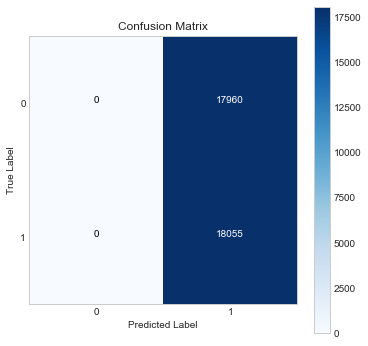

In [54]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_logreg);

AUC: 0.5


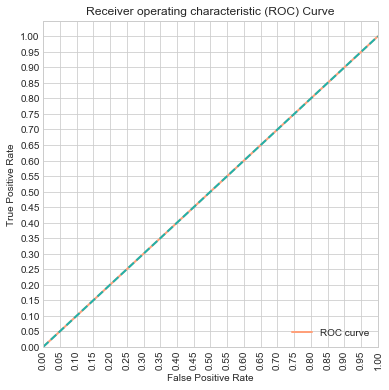

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_logreg)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)],rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

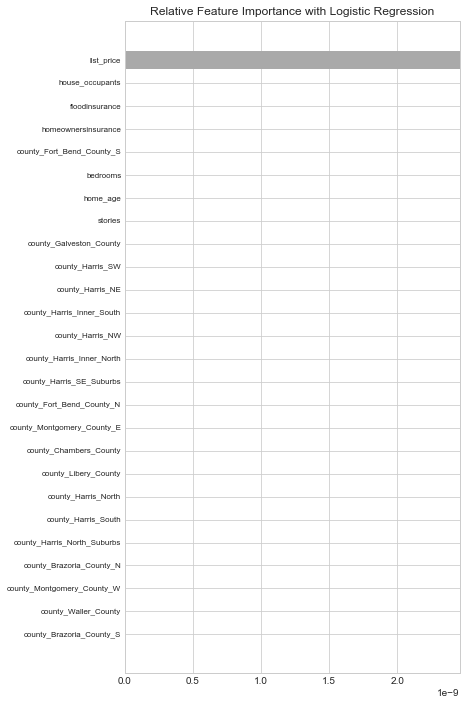

In [56]:
feat_importances_logreg = abs(logreg.coef_[0])/100
sorted_idx = np.argsort(feat_importances_logreg)
pos = np.arange(sorted_idx.shape[0])

featfig = plt.figure(figsize=(6,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feat_importances_logreg[sorted_idx], align='center', color='darkgrey')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_title('Relative Feature Importance with Logistic Regression');

In [57]:
print('10 Most Important Features from Logistic Regression: ')
list(np.array(X.columns)[sorted_idx[::-1]][:10])

10 Most Important Features from Logistic Regression: 


['list_price',
 'house_occupants',
 'floodinsurance',
 'homeownersinsurance',
 'county_Fort_Bend_County_S',
 'bedrooms',
 'home_age',
 'stories',
 'county_Galveston_County',
 'county_Harris_SW']

In [58]:
print('10 Least Important Features from Logistic Regression: ')
list(np.array(X.columns)[sorted_idx[::-1]][-10:])

10 Least Important Features from Logistic Regression: 


['county_Montgomery_County_E',
 'county_Chambers_County',
 'county_Libery_County',
 'county_Harris_North',
 'county_Harris_South',
 'county_Harris_North_Suburbs',
 'county_Brazoria_County_N',
 'county_Montgomery_County_W',
 'county_Waller_County',
 'county_Brazoria_County_S']

In [59]:
# Creating a dataframe to store the model scores

models = pd.DataFrame()

In [60]:
score_logreg = ['Logistic Regression', train_accuracy_logreg, test_accuracy_logreg]
models = models.append([score_logreg])

### XGBoost

In [61]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [62]:
import xgboost as xgb

In [63]:
# instantiate
booster = xgb.XGBClassifier()

# train the xgboost
booster.fit(X_train, y_train)

# predict
train_preds_booster = booster.predict(X_train)
test_preds_booster = booster.predict(X_test)

# evaluate
train_accuracy_booster = accuracy_score(y_train, train_preds_booster)
test_accuracy_booster = accuracy_score(y_test, test_preds_booster)
report_booster = classification_report(y_test, test_preds_booster)

print("XGBoost")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster * 100):.4}%")

print("\nClassification report:")
print(report_booster)
print()

XGBoost
-------------------------
Training Accuracy: 71.19%
Test Accuracy:     71.42%

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     17960
           1       0.70      0.76      0.73     18055

    accuracy                           0.71     36015
   macro avg       0.72      0.71      0.71     36015
weighted avg       0.72      0.71      0.71     36015




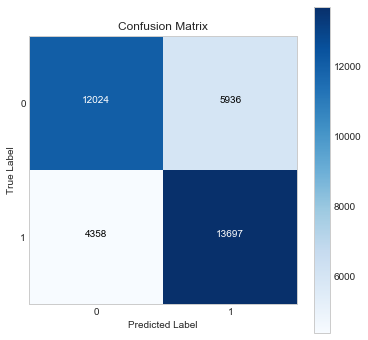

In [64]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster);

AUC: 0.71406


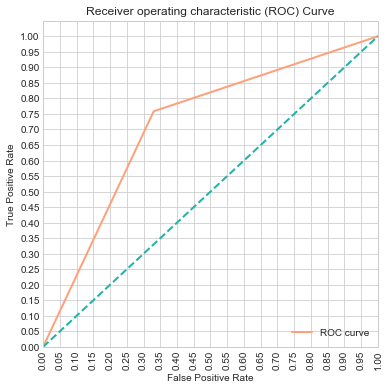

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_booster)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [66]:
booster_feat_weights = pd.DataFrame(booster.feature_importances_, 
                                    columns=['weight'], 
                                    index=X.columns).sort_values('weight', ascending=False)

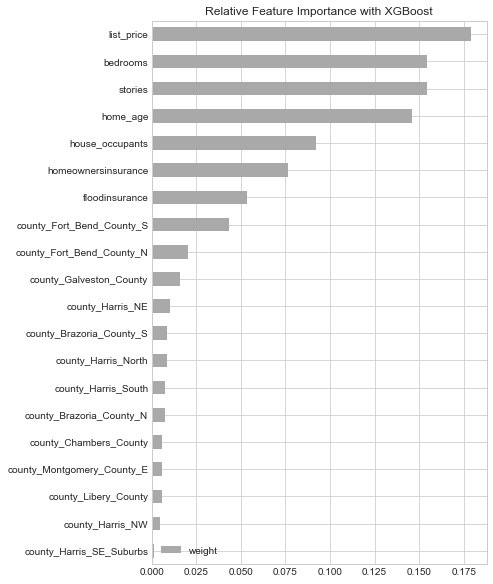

In [67]:
booster_feat_weights[booster_feat_weights.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost');

In [68]:
print('Ranking Features from XGBoost:')
booster_feat_weights.sort_values('weight',ascending=False)

Ranking Features from XGBoost:


,weight
list_price,0.178932
stories,0.154401
bedrooms,0.154401
home_age,0.145743
house_occupants,0.092352
homeownersinsurance,0.076479
floodinsurance,0.053391
county_Fort_Bend_County_S,0.043290
county_Fort_Bend_County_N,0.020202
county_Galveston_County,0.015873


In [69]:
print('Least Important Features from XGBoost:')
print(f'({len(booster_feat_weights[booster_feat_weights.weight==0])} features with weight of 0.0)')
booster_feat_weights[booster_feat_weights.weight==0]

Least Important Features from XGBoost:
(6 features with weight of 0.0)


,weight
county_Montgomery_County_W,0.0
county_Harris_Inner_North,0.0
county_Harris_SW,0.0
county_Harris_North_Suburbs,0.0
county_Harris_Inner_South,0.0
county_Waller_County,0.0


In [70]:
score_xgb = ['XGBoost', train_accuracy_booster, test_accuracy_booster]

#### Looking at Zero-Weight Counties

In [71]:
zero_weight_counties = list(booster_feat_weights[booster_feat_weights.weight==0].index.str[7:])

Flood Damage vs. No Flood Damage in zero weight counties

Number of each value:
1    21427
0    21039
Name: flooddamage, dtype: int64

Percentage of each value:
1    50.46
0    49.54
Name: flooddamage, dtype: float64


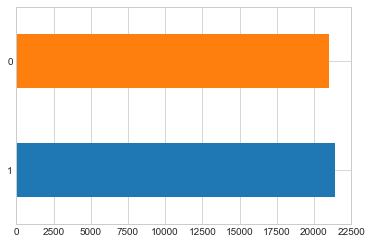

In [72]:
print('Flood Damage vs. No Flood Damage in zero weight counties')
print()
print(f'Number of each value:\n{df_use[df_use.county.isin(zero_weight_counties)].flooddamage.value_counts()}')
print()
print(f'Percentage of each value:\n{round(100*df_use[df_use.county.isin(zero_weight_counties)].flooddamage.value_counts()/len(df_use[df_use.county.isin(zero_weight_counties)]),2)}')

df_use[df_use.county.isin(zero_weight_counties)].flooddamage.value_counts().plot(kind='barh');

MONTGOMERY_COUNTY_W

Number of each value:
0    924
1    706
Name: flooddamage, dtype: int64

Percentage of each value:
0    56.69
1    43.31
Name: flooddamage, dtype: float64


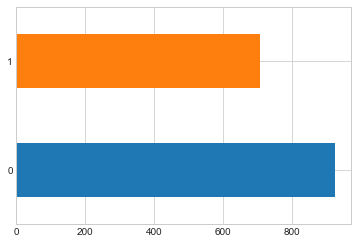


HARRIS_INNER_NORTH

Number of each value:
0    3092
1    2177
Name: flooddamage, dtype: int64

Percentage of each value:
0    58.68
1    41.32
Name: flooddamage, dtype: float64


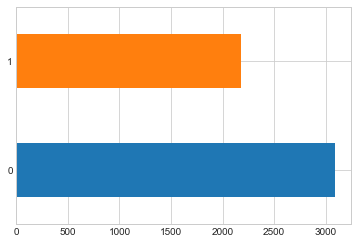


HARRIS_SW

Number of each value:
1    8087
0    4810
Name: flooddamage, dtype: int64

Percentage of each value:
1    62.7
0    37.3
Name: flooddamage, dtype: float64


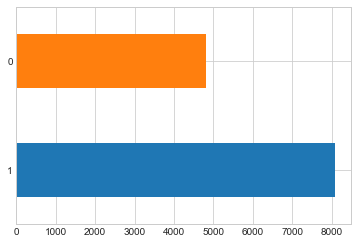


HARRIS_NORTH_SUBURBS

Number of each value:
0    6760
1    6651
Name: flooddamage, dtype: int64

Percentage of each value:
0    50.41
1    49.59
Name: flooddamage, dtype: float64


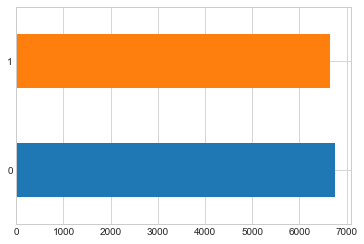


HARRIS_INNER_SOUTH

Number of each value:
0    3986
1    2460
Name: flooddamage, dtype: int64

Percentage of each value:
0    61.84
1    38.16
Name: flooddamage, dtype: float64


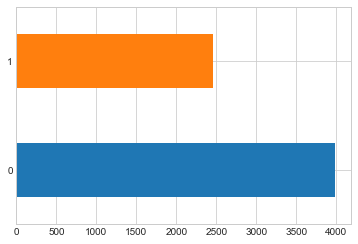


WALLER_COUNTY

Number of each value:
0    1467
1    1346
Name: flooddamage, dtype: int64

Percentage of each value:
0    52.15
1    47.85
Name: flooddamage, dtype: float64


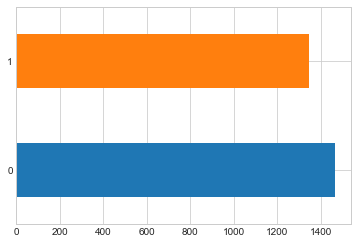

In [73]:
for c in zero_weight_counties:
    print(c.upper())
    print()
    print(f'Number of each value:\n{df_use[df_use.county == c].flooddamage.value_counts()}')
    print()
    print(f'Percentage of each value:\n{round(100*df_use[df_use.county == c].flooddamage.value_counts()/len(df_use[df_use.county == c]),2)}')
    df_use[df_use.county == c].flooddamage.value_counts().plot(kind='barh')
    plt.show()
    print()

#### Looking at Higher-Weight Counties

In [74]:
weighty_counties = booster_feat_weights[booster_feat_weights.sort_values('weight',ascending=False).index.str.startswith('county')].index.str[7:][:5]

In [75]:
weighty_counties

Index(['Fort_Bend_County_S', 'Fort_Bend_County_N', 'Galveston_County',
       'Harris_NE', 'Brazoria_County_S'],
      dtype='object')

FORT_BEND_COUNTY_S

Number of each value:
0    7719
1    1726
Name: flooddamage, dtype: int64

Percentage of each value:
0    81.73
1    18.27
Name: flooddamage, dtype: float64


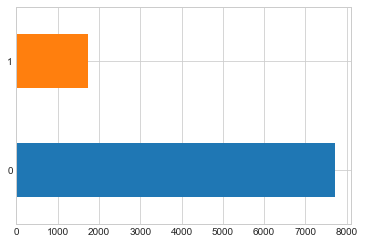


FORT_BEND_COUNTY_N

Number of each value:
0    6189
1    5440
Name: flooddamage, dtype: int64

Percentage of each value:
0    53.22
1    46.78
Name: flooddamage, dtype: float64


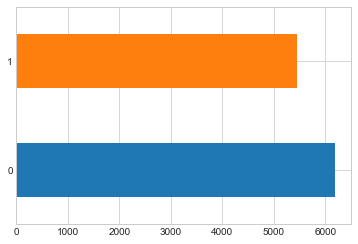


GALVESTON_COUNTY

Number of each value:
1    8696
0    5321
Name: flooddamage, dtype: int64

Percentage of each value:
1    62.04
0    37.96
Name: flooddamage, dtype: float64


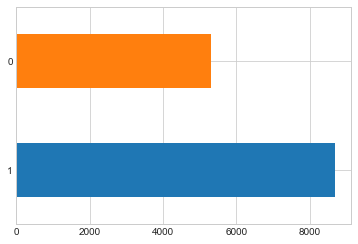


HARRIS_NE

Number of each value:
1    10752
0     8014
Name: flooddamage, dtype: int64

Percentage of each value:
1    57.3
0    42.7
Name: flooddamage, dtype: float64


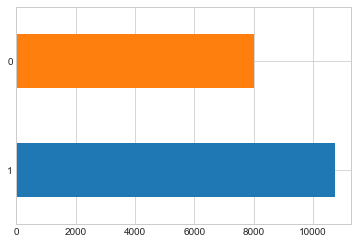


BRAZORIA_COUNTY_S

Number of each value:
1    2397
0    2305
Name: flooddamage, dtype: int64

Percentage of each value:
1    50.98
0    49.02
Name: flooddamage, dtype: float64


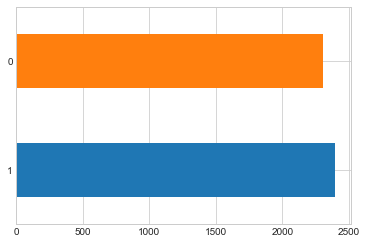

In [76]:
for c in weighty_counties:
    print(c.upper())
    print()
    print(f'Number of each value:\n{df_use[df_use.county == c].flooddamage.value_counts()}')
    print()
    print(f'Percentage of each value:\n{round(100*df_use[df_use.county == c].flooddamage.value_counts()/len(df_use[df_use.county == c]),2)}')
    df_use[df_use.county == c].flooddamage.value_counts().plot(kind='barh')
    plt.show()
    print()

In [77]:
score_xgb = ['XGBoost', train_accuracy_booster, test_accuracy_booster]
models = models.append([score_xgb])

### XGBoost after Removing Low-Ranking Features

In [78]:
booster_feat_weights[booster_feat_weights.weight>0.01].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, list_price to county_Harris_NE
Data columns (total 1 columns):
weight    11 non-null float32
dtypes: float32(1)
memory usage: 132.0+ bytes


In [79]:
X2 = X[booster_feat_weights[booster_feat_weights.weight>0.01].index] # Features
y = df_use['flooddamage'] # Target

In [80]:
# Preview one hot encoded features

view(X2,2)

,list_price,bedrooms,stories,home_age,house_occupants,homeownersinsurance,floodinsurance,county_Fort_Bend_County_S,county_Fort_Bend_County_N,county_Galveston_County,county_Harris_NE
0,160808.871552,3.427108,1.427502,1.612736,2,1,0,1,0,0,0
1,160808.871552,3.427108,1.427502,1.612736,2,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
180069,149389.000000,4.000000,1.500000,1.613660,3,1,0,0,0,0,0
180070,149389.000000,4.000000,1.500000,1.613660,2,1,0,0,0,0,0


In [81]:
# Separating the data into a training and testing set

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2)

print(f"Training set has {X2_train.shape[0]} samples")
print(f"Testing set has {X2_test.shape[0]} samples")

Training set has 144056 samples
Testing set has 36015 samples


In [82]:
# instantiate
booster2 = xgb.XGBClassifier()

# train the xgboost
booster2.fit(X2_train, y_train)

# predict
train_preds_booster2 = booster2.predict(X2_train)
test_preds_booster2 = booster2.predict(X2_test)

# evaluate
train_accuracy_booster2 = accuracy_score(y_train, train_preds_booster2)
test_accuracy_booster2 = accuracy_score(y_test, test_preds_booster2)
report_booster2 = classification_report(y_test, test_preds_booster2)

print("XGBoost 2")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster2 * 100):.4}%")

print("\nClassification report:")
print(report_booster2)
print()

XGBoost 2
-------------------------
Training Accuracy: 71.24%
Test Accuracy:     71.47%

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     17960
           1       0.70      0.77      0.73     18055

    accuracy                           0.71     36015
   macro avg       0.72      0.71      0.71     36015
weighted avg       0.72      0.71      0.71     36015




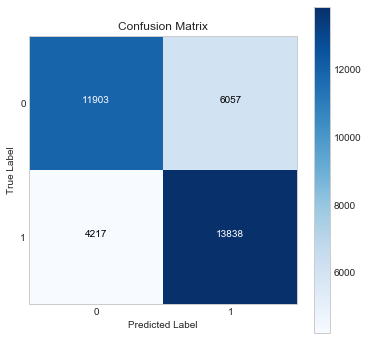

In [83]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster2);

AUC: 0.71459


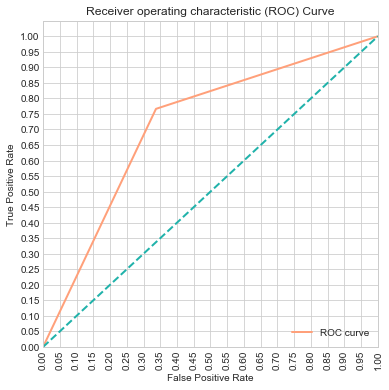

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_booster2)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [85]:
booster_feat_weights2 = pd.DataFrame(booster2.feature_importances_, 
                                    columns=['weight'], 
                                    index=X2.columns).sort_values('weight', ascending=False)

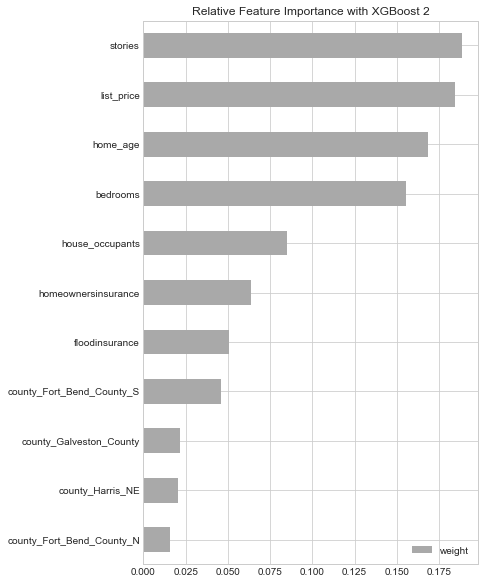

In [86]:
booster_feat_weights2[booster_feat_weights2.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost 2');

In [87]:
print('Most Important Features from XGBoost 2:')
booster_feat_weights2.sort_values('weight',ascending=False)

Most Important Features from XGBoost 2:


,weight
stories,0.188761
list_price,0.184438
home_age,0.168588
bedrooms,0.155620
house_occupants,0.085014
homeownersinsurance,0.063401
floodinsurance,0.050432
county_Fort_Bend_County_S,0.046110
county_Galveston_County,0.021614
county_Harris_NE,0.020173


In [88]:
score_xgb2 = ['XGBoost2', train_accuracy_booster2, test_accuracy_booster2]

### XGBoost without County Features

In [89]:
list(X.columns)[:8]

['house_occupants',
 'homeownersinsurance',
 'floodinsurance',
 'list_price',
 'bedrooms',
 'stories',
 'home_age',
 'county_Brazoria_County_N']

In [90]:
X3 = X[list(X.columns)[:8]] # Features
y = df_use['flooddamage'] # Target

In [91]:
# Preview one hot encoded features

view(X3,2)

,house_occupants,homeownersinsurance,floodinsurance,list_price,bedrooms,stories,home_age,county_Brazoria_County_N
0,2,1,0,160808.871552,3.427108,1.427502,1.612736,0
1,2,1,0,160808.871552,3.427108,1.427502,1.612736,0
...,...,...,...,...,...,...,...,...
180069,3,1,0,149389.000000,4.000000,1.500000,1.613660,0
180070,2,1,0,149389.000000,4.000000,1.500000,1.613660,0


In [92]:
# Separating the data into a training and testing set

X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2)

print(f"Training set has {X3_train.shape[0]} samples")
print(f"Testing set has {X3_test.shape[0]} samples")

Training set has 144056 samples
Testing set has 36015 samples


In [93]:
# instantiate
booster3 = xgb.XGBClassifier()

# train the xgboost
booster3.fit(X3_train, y_train)

# predict
train_preds_booster3 = booster3.predict(X3_train)
test_preds_booster3 = booster3.predict(X3_test)

# evaluate
train_accuracy_booster3 = accuracy_score(y_train, train_preds_booster3)
test_accuracy_booster3 = accuracy_score(y_test, test_preds_booster3)
report_booster3 = classification_report(y_test, test_preds_booster3)

print("XGBoost 3")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster3 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster3 * 100):.4}%")

print("\nClassification report:")
print(report_booster3)
print()

XGBoost 3
-------------------------
Training Accuracy: 71.14%
Test Accuracy:     71.44%

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70     17960
           1       0.70      0.76      0.73     18055

    accuracy                           0.71     36015
   macro avg       0.72      0.71      0.71     36015
weighted avg       0.72      0.71      0.71     36015




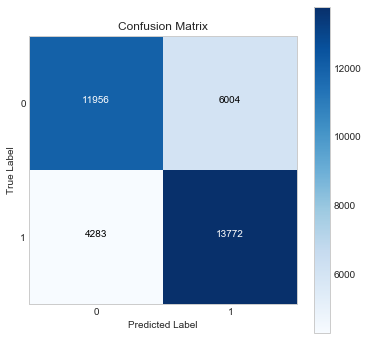

In [94]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster3);

AUC: 0.71424


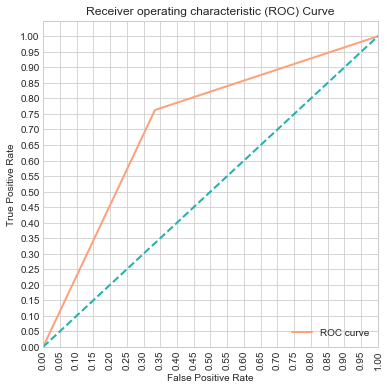

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_booster3)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [96]:
booster_feat_weights3 = pd.DataFrame(booster3.feature_importances_, 
                                    columns=['weight'], 
                                    index=X3.columns).sort_values('weight', ascending=False)

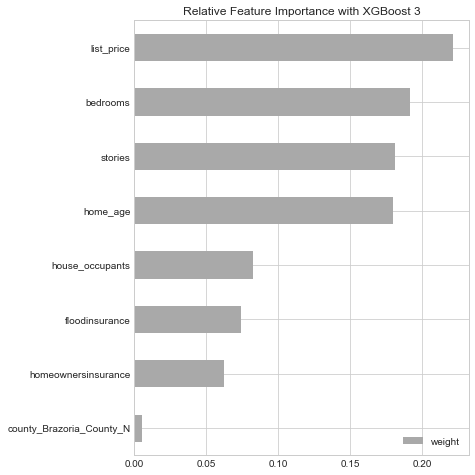

In [97]:
booster_feat_weights3[booster_feat_weights3.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,8))
plt.title('Relative Feature Importance with XGBoost 3');

In [98]:
print('Most Important Features from XGBoost 3:')
booster_feat_weights3.sort_values('weight',ascending=False)

Most Important Features from XGBoost 3:


,weight
list_price,0.221429
bedrooms,0.191429
stories,0.181429
home_age,0.180000
house_occupants,0.082857
floodinsurance,0.074286
homeownersinsurance,0.062857
county_Brazoria_County_N,0.005714


In [99]:
score_xgb3 = ['XGBoost', train_accuracy_booster3, test_accuracy_booster3]

## Interpretation and Conclusions

In [100]:
models = pd.DataFrame()

In [101]:
models = models.append([score_xgb, score_xgb2, score_xgb3])

In [102]:
models

,0,1,2
0,XGBoost,0.711945,0.714175
1,XGBoost2,0.712404,0.714730
2,XGBoost,0.711411,0.714369


### Comparing the Models

In [103]:
models.columns = ['Model', 'Training Accuracy', 'Testing Accuracy']
models.set_index(['Model'], inplace=True)

models

,Training Accuracy,Testing Accuracy
Model,,
XGBoost,0.711945,0.714175
XGBoost2,0.712404,0.714730
XGBoost,0.711411,0.714369


In [104]:
# Sorted by testing accuracy

models.sort_values(['Testing Accuracy'], ascending=False)

,Training Accuracy,Testing Accuracy
Model,,
XGBoost2,0.712404,0.714730
XGBoost,0.711411,0.714369
XGBoost,0.711945,0.714175


The highest performing model I made gave a predictive value of 71.47%. This model took the relative feature weightings from the original XGBoost model and removed the lowest performing features, which turned out to be a few of the county divisions.

## Follow up EDA

In [105]:
view(df,2)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,bedrooms,stories,home_age
0,77489,2,True,False,False,160808.871552,3.427108,1.427502,29.936958
1,77489,2,True,False,False,160808.871552,3.427108,1.427502,29.936958
...,...,...,...,...,...,...,...,...,...
180069,78944,3,True,False,False,149389.000000,4.000000,1.500000,30.000000
180070,78944,2,True,False,True,149389.000000,4.000000,1.500000,30.000000


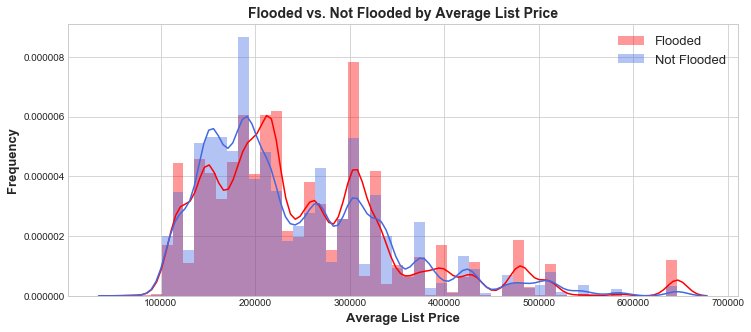

In [106]:
# Visualizing the difference flooded vs. not flooded by average list price

plt.figure(figsize=(12,5))
sns.distplot(df[df.flooddamage==True].list_price, bins=50, label="Flooded", color='red')
sns.distplot(df[df.flooddamage==False].list_price, bins=50, label="Not Flooded", color='royalblue')
plt.title("Flooded vs. Not Flooded by Average List Price", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average List Price", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 91370
Number of Unique Values: 213
Number of nulls: 0 - 0.0%

Mean: 248951.8232466007
Minimum: 65975.0
Lower Quartile: 177034.31377277602
Median: 218557.0946345585
Upper Quartile: 306716.97643979057
Maximum: 646146.8912783753


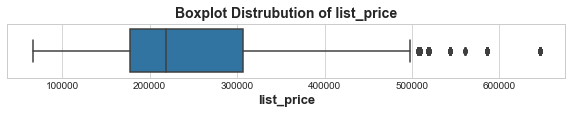

In [107]:
stats(df[df.flooddamage==True],'list_price')

Data type: float64
Count: 88701
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 240211.09310972903
Minimum: 65975.0
Lower Quartile: 163757.5835117773
Median: 213580.6462093863
Upper Quartile: 301818.04891904694
Maximum: 646146.8912783753


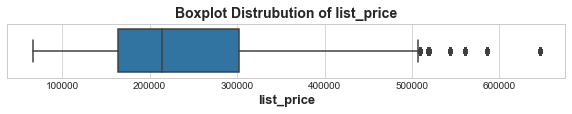

In [108]:
stats(df[df.flooddamage==False],'list_price')

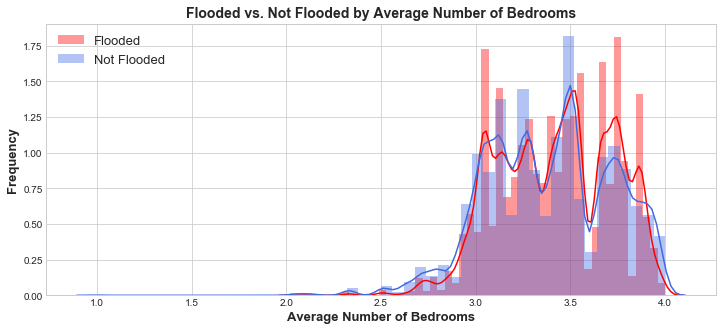

In [109]:
# Visualizing the difference flooded vs. not flooded by average number of bedrooms

plt.figure(figsize=(12,5))
sns.distplot(df[df.flooddamage==True].bedrooms, bins=50, label="Flooded", color='red')
sns.distplot(df[df.flooddamage==False].bedrooms, bins=50, label="Not Flooded", color='royalblue')
plt.title("Flooded vs. Not Flooded by Average Number of Bedrooms", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Bedrooms", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 91370
Number of Unique Values: 211
Number of nulls: 0 - 0.0%

Mean: 3.423504438261675
Minimum: 2.06
Lower Quartile: 3.1750503018108653
Median: 3.4540023894862606
Upper Quartile: 3.6732142857142858
Maximum: 4.0


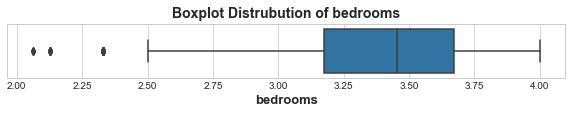

In [110]:
stats(df[df.flooddamage==True],'bedrooms')

Data type: float64
Count: 88701
Number of Unique Values: 214
Number of nulls: 0 - 0.0%

Mean: 3.3841955180922363
Minimum: 1.0
Lower Quartile: 3.1320754716981134
Median: 3.4068241469816267
Upper Quartile: 3.660484481453445
Maximum: 4.0


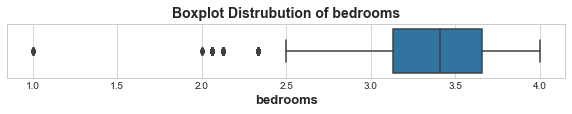

In [111]:
stats(df[df.flooddamage==False],'bedrooms')

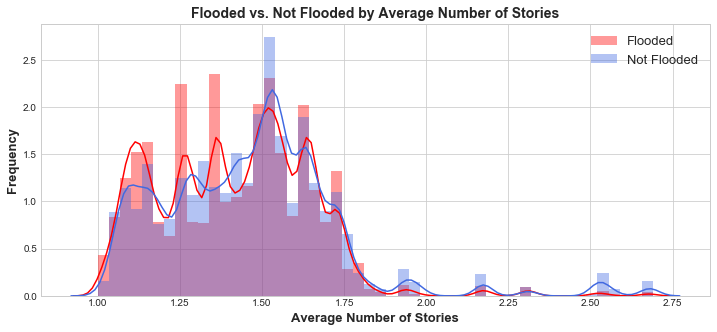

In [112]:
# Visualizing the difference flooded vs. not flooded by average number of stories

plt.figure(figsize=(12,5))
sns.distplot(df[df.flooddamage==True].stories, bins=50, label="Flooded", color='red')
sns.distplot(df[df.flooddamage==False].stories, bins=50, label="Not Flooded", color='royalblue')
plt.title("Flooded vs. Not Flooded by Average Number of Stories", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Stories", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 91370
Number of Unique Values: 211
Number of nulls: 0 - 0.0%

Mean: 1.4162011628192168
Minimum: 1.0
Lower Quartile: 1.255247376311844
Median: 1.42282019190655
Upper Quartile: 1.567169540229885
Maximum: 2.6904761904761907


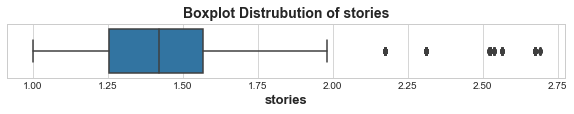

In [113]:
stats(df[df.flooddamage==True],'stories')

Data type: float64
Count: 88701
Number of Unique Values: 212
Number of nulls: 0 - 0.0%

Mean: 1.4621074810558354
Minimum: 1.0
Lower Quartile: 1.2717391304347827
Median: 1.47460757156048
Upper Quartile: 1.6092094539527302
Maximum: 2.6904761904761907


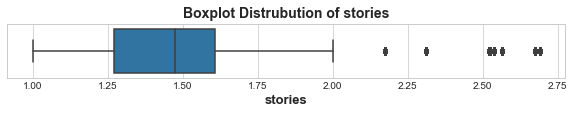

In [114]:
stats(df[df.flooddamage==False],'stories')

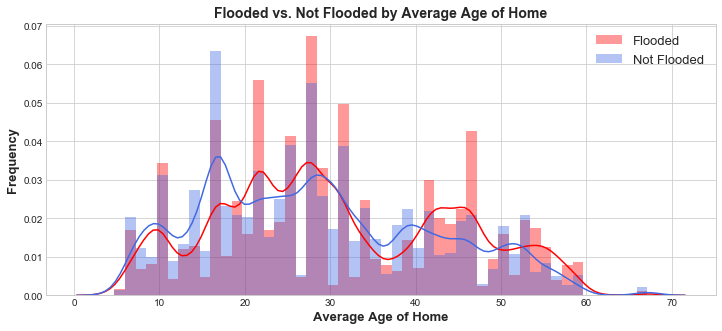

In [115]:
# Visualizing the difference flooded vs. not flooded by average age of home

plt.figure(figsize=(12,5))
sns.distplot(df[df.flooddamage==True].home_age, bins=50, label="Flooded", color='red')
sns.distplot(df[df.flooddamage==False].home_age, bins=50, label="Not Flooded", color='royalblue')
plt.title("Flooded vs. Not Flooded by Average Age of Home", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Age of Home", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 91370
Number of Unique Values: 213
Number of nulls: 0 - 0.0%

Mean: 30.73774345239824
Minimum: 4.705882352941177
Lower Quartile: 21.35893918609968
Median: 27.999242997728988
Upper Quartile: 42.60709219858156
Maximum: 67.17307692307692


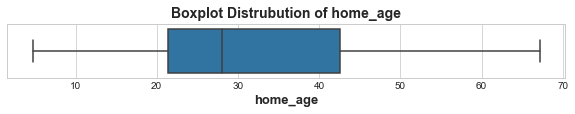

In [116]:
stats(df[df.flooddamage==True],'home_age')

Data type: float64
Count: 88701
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 28.656334223292564
Minimum: 4.705882352941177
Lower Quartile: 17.208263069139967
Median: 27.340637450199203
Upper Quartile: 38.79874213836478
Maximum: 67.17307692307692


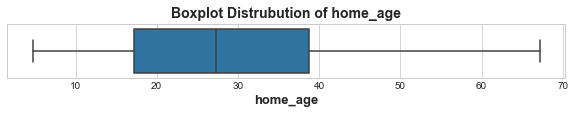

In [117]:
stats(df[df.flooddamage==False],'home_age')

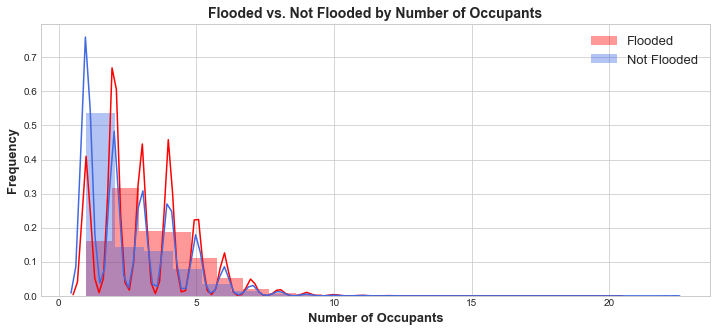

In [118]:
# Visualizing the difference flooded vs. not flooded by number of occupants

plt.figure(figsize=(12,5))
sns.distplot(df[df.flooddamage==True].house_occupants, bins=20, label="Flooded", color='red')
sns.distplot(df[df.flooddamage==False].house_occupants, bins=20, label="Not Flooded", color='royalblue')
plt.title("Flooded vs. Not Flooded by Number of Occupants", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Number of Occupants", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: int64
Count: 91370
Number of Unique Values: 18
Number of nulls: 0 - 0.0%

Mean: 3.095217248549852
Minimum: 1
Lower Quartile: 2.0
Median: 3.0
Upper Quartile: 4.0
Maximum: 20


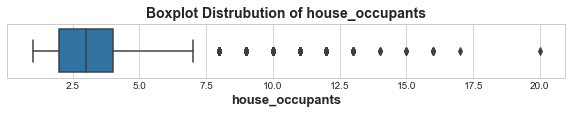

In [119]:
stats(df[df.flooddamage==True],'house_occupants')

Data type: int64
Count: 88701
Number of Unique Values: 19
Number of nulls: 0 - 0.0%

Mean: 2.6259004971759055
Minimum: 1
Lower Quartile: 1.0
Median: 2.0
Upper Quartile: 4.0
Maximum: 22


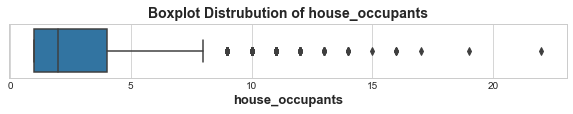

In [120]:
stats(df[df.flooddamage==False],'house_occupants')

### Adding County Column

In [121]:
df['county'] = pd.Series()

In [122]:
df.loc[df.zip_code.isin(Austin_County), 'county'] = 'Austin_County'
df.loc[df.zip_code.isin(Brazoria_County_N), 'county'] = 'Brazoria_County_N'
df.loc[df.zip_code.isin(Brazoria_County_S), 'county'] = 'Brazoria_County_S'
df.loc[df.zip_code.isin(Chambers_County), 'county'] = 'Chambers_County'
df.loc[df.zip_code.isin(Fort_Bend_County_N), 'county'] = 'Fort_Bend_County_N'
df.loc[df.zip_code.isin(Fort_Bend_County_S), 'county'] = 'Fort_Bend_County_S'
df.loc[df.zip_code.isin(Galveston_County), 'county'] = 'Galveston_County'
df.loc[df.zip_code.isin(Harris_Inner_North), 'county'] = 'Harris_Inner_North'
df.loc[df.zip_code.isin(Harris_Inner_South), 'county'] = 'Harris_Inner_South'
df.loc[df.zip_code.isin(Harris_NE), 'county'] = 'Harris_NE'
df.loc[df.zip_code.isin(Harris_North), 'county'] = 'Harris_North'
df.loc[df.zip_code.isin(Harris_North_Suburbs), 'county'] = 'Harris_North_Suburbs'
df.loc[df.zip_code.isin(Harris_NW), 'county'] = 'Harris_NW'
df.loc[df.zip_code.isin(Harris_SE_Suburbs), 'county'] = 'Harris_SE_Suburbs'
df.loc[df.zip_code.isin(Harris_South), 'county'] = 'Harris_South'
df.loc[df.zip_code.isin(Harris_SW), 'county'] = 'Harris_SW'
df.loc[df.zip_code.isin(Libery_County), 'county'] = 'Libery_County'
df.loc[df.zip_code.isin(Montgomery_County_E), 'county'] = 'Montgomery_County_E'
df.loc[df.zip_code.isin(Montgomery_County_W), 'county'] = 'Montgomery_County_W'
df.loc[df.zip_code.isin(Waller_County), 'county'] = 'Waller_County'

### Fort Bend County South: Least Flooded County

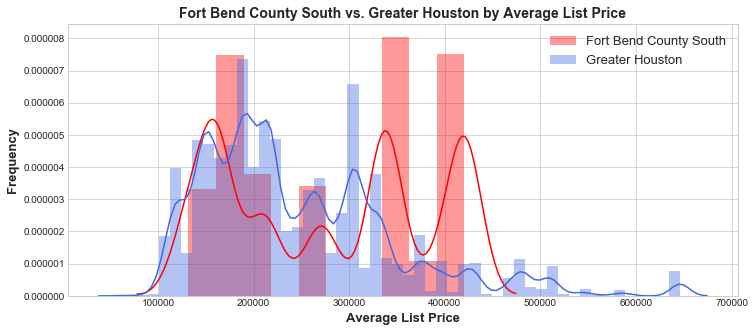

In [123]:
# Visualizing the difference between Fort Bend County South and Greater Houston by average list price

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Fort_Bend_County_S'].list_price, bins=10, label="Fort Bend County South", color='red')
sns.distplot(df.list_price, bins=50, label="Greater Houston", color='royalblue')
plt.title("Fort Bend County South vs. Greater Houston by Average List Price", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average List Price", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 9445
Number of Unique Values: 9
Number of nulls: 0 - 0.0%

Mean: 278827.4920846024
Minimum: 131719.10986964614
Lower Quartile: 160808.87155240346
Median: 271824.42797546013
Upper Quartile: 337790.3896729776
Maximum: 420458.7461167648


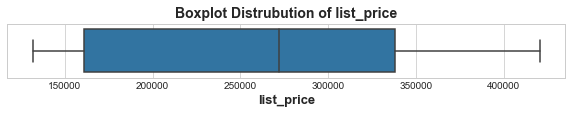

In [124]:
stats(df[df.county=='Fort_Bend_County_S'],'list_price')

Data type: float64
Count: 180071
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 244646.23542918052
Minimum: 65975.0
Lower Quartile: 171265.7619680851
Median: 217999.58193979933
Upper Quartile: 306716.97643979057
Maximum: 646146.8912783753


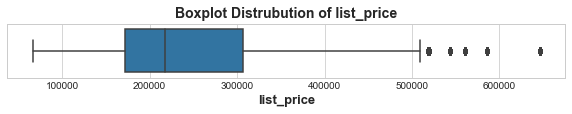

In [125]:
stats(df,'list_price')

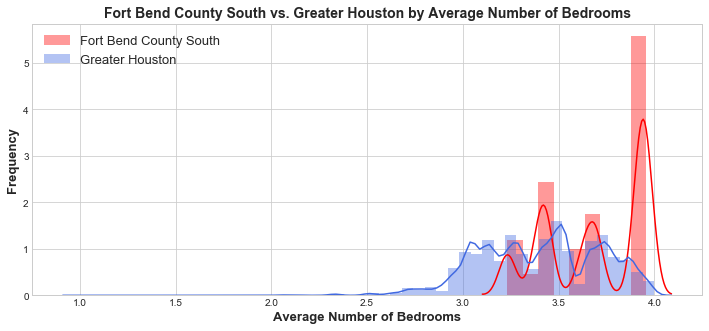

In [126]:
# Visualizing the difference between Fort Bend County South and Greater Houston by average number of bedrooms

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Fort_Bend_County_S'].bedrooms, bins=9, label="Fort Bend County South", color='red')
sns.distplot(df.bedrooms, bins=50, label="Greater Houston", color='royalblue')
plt.title("Fort Bend County South vs. Greater Houston by Average Number of Bedrooms", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Bedrooms", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 9445
Number of Unique Values: 9
Number of nulls: 0 - 0.0%

Mean: 3.689908970175298
Minimum: 3.2327746741154564
Lower Quartile: 3.4271079590228526
Median: 3.689097103918228
Upper Quartile: 3.9249569707401033
Maximum: 3.958043206570255


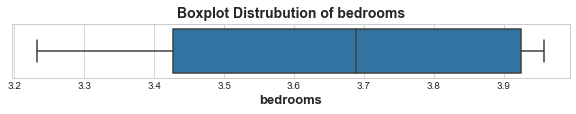

In [127]:
stats(df[df.county=='Fort_Bend_County_S'],'bedrooms')

Data type: float64
Count: 180071
Number of Unique Values: 214
Number of nulls: 0 - 0.0%

Mean: 3.4041412952350383
Minimum: 1.0
Lower Quartile: 3.143478260869565
Median: 3.4110688635403466
Upper Quartile: 3.6732142857142858
Maximum: 4.0


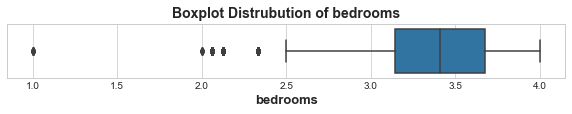

In [128]:
stats(df,'bedrooms')

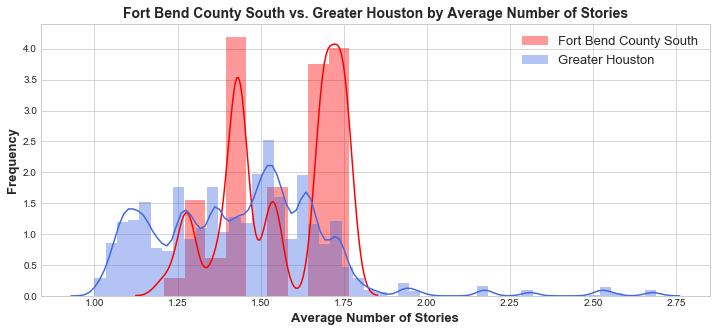

In [129]:
# Visualizing the difference between Fort Bend County South and Greater Houston by average number of stories

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Fort_Bend_County_S'].stories, bins=9, label="Fort Bend County South", color='red')
sns.distplot(df.stories, bins=50, label="Greater Houston", color='royalblue')
plt.title("Fort Bend County South vs. Greater Houston by Average Number of Stories", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Stories", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 9445
Number of Unique Values: 9
Number of nulls: 0 - 0.0%

Mean: 1.5606274590852327
Minimum: 1.2100694444444444
Lower Quartile: 1.4275019700551614
Median: 1.536626916524702
Upper Quartile: 1.6906196213425129
Maximum: 1.766347687400319


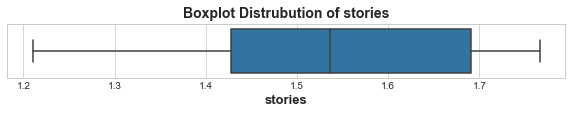

In [130]:
stats(df[df.county=='Fort_Bend_County_S'],'stories')

Data type: float64
Count: 180071
Number of Unique Values: 212
Number of nulls: 0 - 0.0%

Mean: 1.438814111788825
Minimum: 1.0
Lower Quartile: 1.2565217391304349
Median: 1.4574695447745245
Upper Quartile: 1.593681917211329
Maximum: 2.6904761904761907


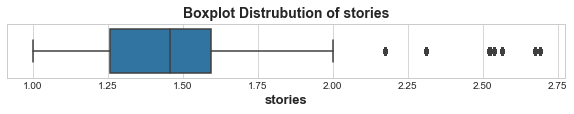

In [131]:
stats(df,'stories')

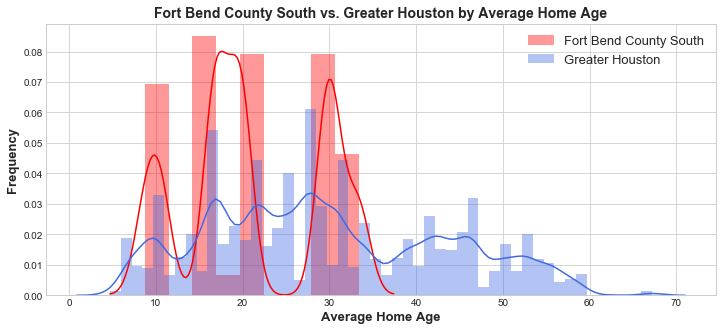

In [132]:
# Visualizing the difference between Fort Bend County South and Greater Houston by average age of home

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Fort_Bend_County_S'].home_age, bins=9, label="Fort Bend County South", color='red')
sns.distplot(df.home_age, bins=50, label="Greater Houston", color='royalblue')
plt.title("Fort Bend County South vs. Greater Houston by Average Home Age", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Home Age", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 9445
Number of Unique Values: 9
Number of nulls: 0 - 0.0%

Mean: 21.02607938385933
Minimum: 8.764171779141105
Lower Quartile: 16.889500860585198
Median: 19.80324941974648
Upper Quartile: 29.936958234830573
Maximum: 33.361266294227185


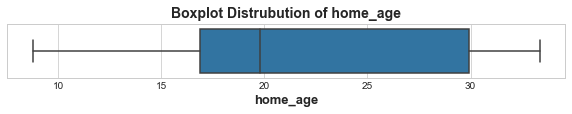

In [133]:
stats(df[df.county=='Fort_Bend_County_S'],'home_age')

Data type: float64
Count: 180071
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 29.71246409019721
Minimum: 4.705882352941177
Lower Quartile: 19.028049575994785
Median: 27.87205882352941
Upper Quartile: 41.39784946236559
Maximum: 67.17307692307692


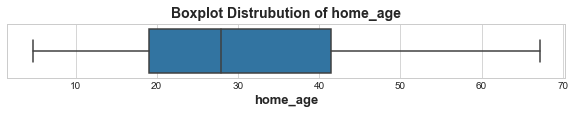

In [134]:
stats(df,'home_age')

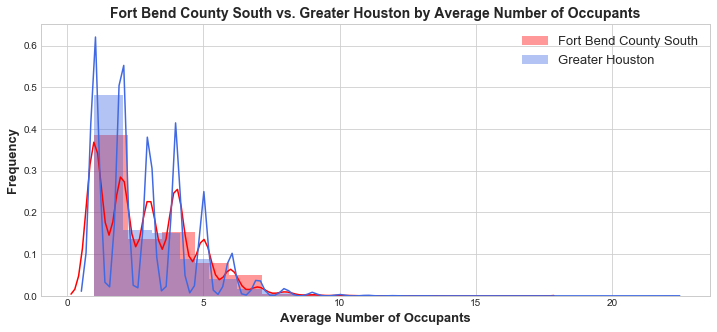

In [135]:
# Visualizing the difference between Fort Bend County South and Greater Houston by average Number of Occupants

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Fort_Bend_County_S'].house_occupants, bins=13, label="Fort Bend County South", color='red')
sns.distplot(df.house_occupants, bins=20, label="Greater Houston", color='royalblue')
plt.title("Fort Bend County South vs. Greater Houston by Average Number of Occupants", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Occupants", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: int64
Count: 9445
Number of Unique Values: 13
Number of nulls: 0 - 0.0%

Mean: 2.8984647961884593
Minimum: 1
Lower Quartile: 1.0
Median: 3.0
Upper Quartile: 4.0
Maximum: 17


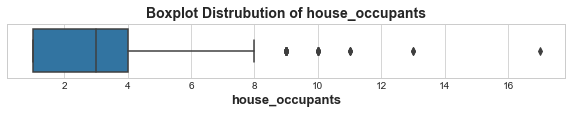

In [136]:
stats(df[df.county=='Fort_Bend_County_S'],'house_occupants')

Data type: int64
Count: 180071
Number of Unique Values: 20
Number of nulls: 0 - 0.0%

Mean: 2.86403696319785
Minimum: 1
Lower Quartile: 1.0
Median: 2.0
Upper Quartile: 4.0
Maximum: 22


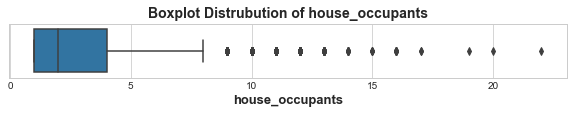

In [137]:
stats(df,'house_occupants')

### Galveston County: Most Flooded County

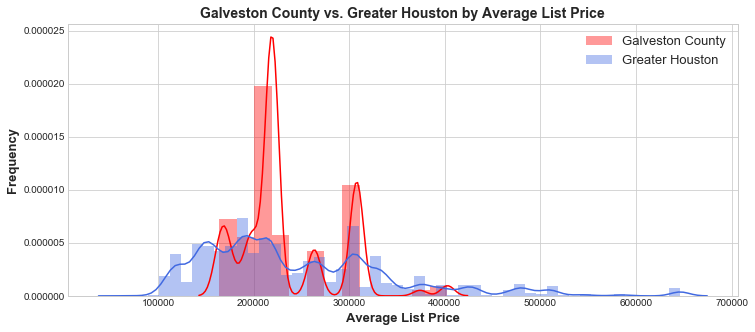

In [138]:
# Visualizing the difference between Galveston County and Greater Houston by average list price

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Galveston_County'].list_price, bins=13, label="Galveston County", color='red')
sns.distplot(df.list_price, bins=50, label="Greater Houston", color='royalblue')
plt.title("Galveston County vs. Greater Houston by Average List Price", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average List Price", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 14017
Number of Unique Values: 13
Number of nulls: 0 - 0.0%

Mean: 234418.5864560145
Minimum: 163757.5835117773
Lower Quartile: 203999.11809045228
Median: 218557.0946345585
Upper Quartile: 264430.3045977011
Maximum: 402739.48364485975


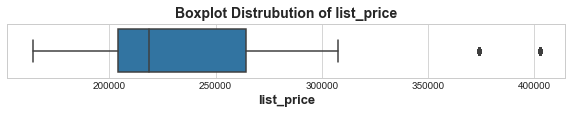

In [139]:
stats(df[df.county=='Galveston_County'],'list_price')

Data type: float64
Count: 180071
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 244646.23542918052
Minimum: 65975.0
Lower Quartile: 171265.7619680851
Median: 217999.58193979933
Upper Quartile: 306716.97643979057
Maximum: 646146.8912783753


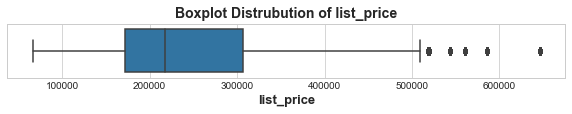

In [140]:
stats(df,'list_price')

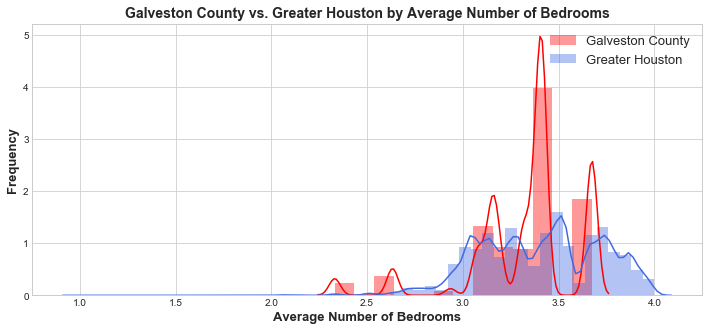

In [141]:
# Visualizing the difference between Galveston County and Greater Houston by average number of bedrooms

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Galveston_County'].bedrooms, bins=13, label="Galveston County", color='red')
sns.distplot(df.bedrooms, bins=50, label="Greater Houston", color='royalblue')
plt.title("Galveston County vs. Greater Houston by Average Number of Bedrooms", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Bedrooms", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()


Data type: float64
Count: 14017
Number of Unique Values: 13
Number of nulls: 0 - 0.0%

Mean: 3.3259278877154883
Minimum: 2.330791229742612
Lower Quartile: 3.160164271047228
Median: 3.4110688635403466
Upper Quartile: 3.4110688635403466
Maximum: 3.6732142857142858


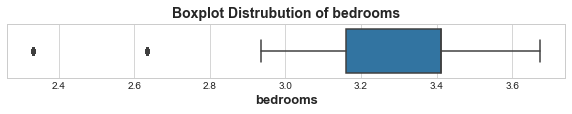

In [142]:
stats(df[df.county=='Galveston_County'],'bedrooms')

Data type: float64
Count: 180071
Number of Unique Values: 214
Number of nulls: 0 - 0.0%

Mean: 3.4041412952350383
Minimum: 1.0
Lower Quartile: 3.143478260869565
Median: 3.4110688635403466
Upper Quartile: 3.6732142857142858
Maximum: 4.0


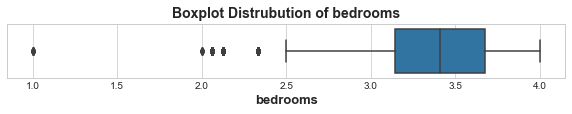

In [143]:
stats(df,'bedrooms')

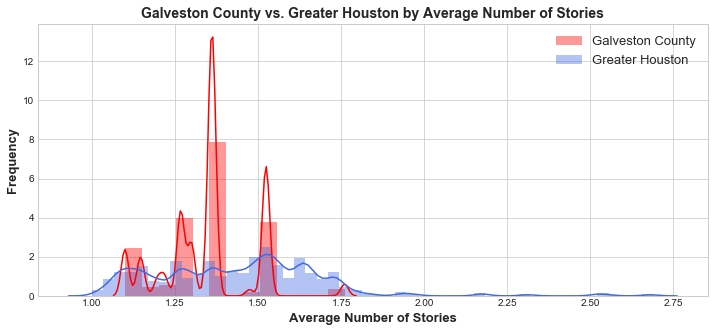

In [144]:
# Visualizing the difference between Galveston County and Greater Houston by average number of stories

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Galveston_County'].stories, bins=13, label="Galveston County", color='red')
sns.distplot(df.stories, bins=50, label="Greater Houston", color='royalblue')
plt.title("Galveston County vs. Greater Houston by Average Number of Stories", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Stories", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 14017
Number of Unique Values: 13
Number of nulls: 0 - 0.0%

Mean: 1.3458560679997105
Minimum: 1.0995893223819302
Lower Quartile: 1.2666223404255321
Median: 1.3610054921841994
Upper Quartile: 1.3657303370786518
Maximum: 1.7605140186915889


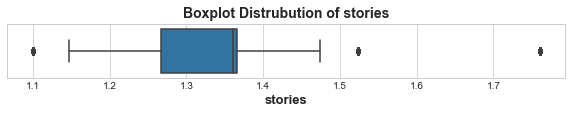

In [145]:
stats(df[df.county=='Galveston_County'],'stories')

Data type: float64
Count: 180071
Number of Unique Values: 212
Number of nulls: 0 - 0.0%

Mean: 1.438814111788825
Minimum: 1.0
Lower Quartile: 1.2565217391304349
Median: 1.4574695447745245
Upper Quartile: 1.593681917211329
Maximum: 2.6904761904761907


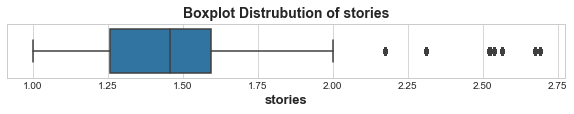

In [146]:
stats(df,'stories')

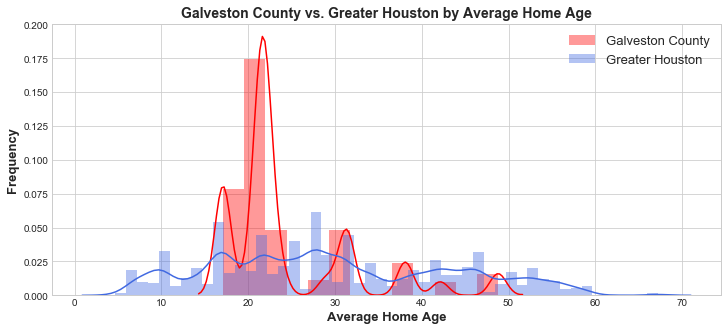

In [147]:
# Visualizing the difference between Galveston County and Greater Houston by average age of home

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Galveston_County'].home_age, bins=13, label="Galveston County", color='red')
sns.distplot(df.home_age, bins=50, label="Greater Houston", color='royalblue')
plt.title("Galveston County vs. Greater Houston by Average Home Age", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Home Age", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: float64
Count: 14017
Number of Unique Values: 13
Number of nulls: 0 - 0.0%

Mean: 24.666899020963562
Minimum: 17.10214285714286
Lower Quartile: 20.876329787234038
Median: 21.70468948035488
Upper Quartile: 28.94701986754967
Maximum: 48.802247191011226


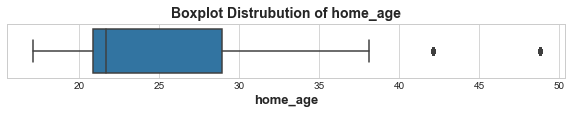

In [148]:
stats(df[df.county=='Galveston_County'],'home_age')

Data type: float64
Count: 180071
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 29.71246409019721
Minimum: 4.705882352941177
Lower Quartile: 19.028049575994785
Median: 27.87205882352941
Upper Quartile: 41.39784946236559
Maximum: 67.17307692307692


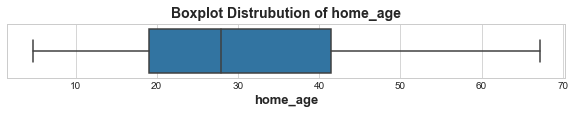

In [149]:
stats(df,'home_age')

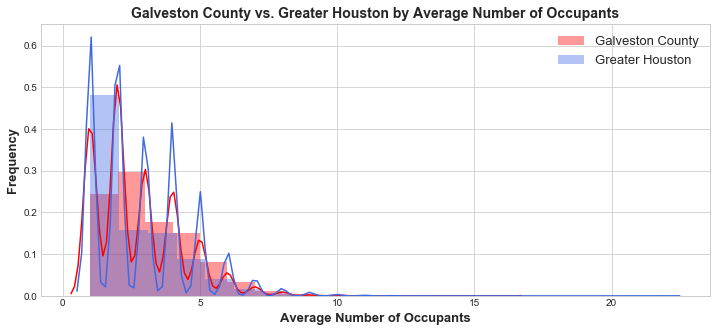

In [150]:
# Visualizing the difference between Galveston County and Greater Houston by average Number of Occupants

plt.figure(figsize=(12,5))
sns.distplot(df[df.county=='Galveston_County'].house_occupants, bins=15, label="Galveston County", color='red')
sns.distplot(df.house_occupants, bins=20, label="Greater Houston", color='royalblue')
plt.title("Galveston County vs. Greater Houston by Average Number of Occupants", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Average Number of Occupants", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

Data type: int64
Count: 14017
Number of Unique Values: 15
Number of nulls: 0 - 0.0%

Mean: 2.722551187843333
Minimum: 1
Lower Quartile: 2.0
Median: 2.0
Upper Quartile: 4.0
Maximum: 16


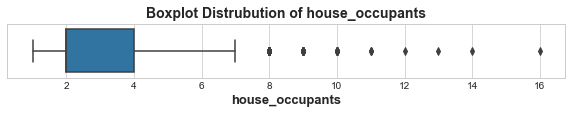

In [151]:
stats(df[df.county=='Galveston_County'],'house_occupants')

Data type: int64
Count: 180071
Number of Unique Values: 20
Number of nulls: 0 - 0.0%

Mean: 2.86403696319785
Minimum: 1
Lower Quartile: 1.0
Median: 2.0
Upper Quartile: 4.0
Maximum: 22


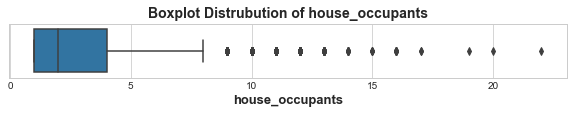

In [152]:
stats(df,'house_occupants')

## Predictions

In [153]:
for i, flooddamage in enumerate(booster2.predict(X2.head(10))): 
    print("Predicted quality for home {} is: {}".format(i+1, flooddamage))

Predicted quality for home 1 is: 0
Predicted quality for home 2 is: 0
Predicted quality for home 3 is: 0
Predicted quality for home 4 is: 0
Predicted quality for home 5 is: 0
Predicted quality for home 6 is: 0
Predicted quality for home 7 is: 0
Predicted quality for home 8 is: 0
Predicted quality for home 9 is: 0
Predicted quality for home 10 is: 0


In [154]:
import collections

In [155]:
collections.Counter(booster2.predict(X2))

Counter({0: 79969, 1: 100102})

In [156]:
y.value_counts()

1    91370
0    88701
Name: flooddamage, dtype: int64

In [157]:
X2.head()

,list_price,bedrooms,stories,home_age,house_occupants,homeownersinsurance,floodinsurance,county_Fort_Bend_County_S,county_Fort_Bend_County_N,county_Galveston_County,county_Harris_NE
0,160808.871552,3.427108,1.427502,1.612736,2,1,0,1,0,0,0
1,160808.871552,3.427108,1.427502,1.612736,2,1,0,1,0,0,0
2,160808.871552,3.427108,1.427502,1.612736,5,1,0,1,0,0,0
3,160808.871552,3.427108,1.427502,1.612736,1,1,0,1,0,0,0
4,160808.871552,3.427108,1.427502,1.612736,5,0,0,1,0,0,0


In [158]:
booster_results2 = pd.Series(booster2.predict(X2))

In [159]:
booster_results2.value_counts()

1    100102
0     79969
dtype: int64

In [160]:
zip_predicts = pd.DataFrame(df.zip_code)

In [161]:
zip_predicts.shape

(180071, 1)

In [162]:
zip_predicts['likely_flooded'] = booster_results2

In [163]:
for z in list(zip_predicts.zip_code.unique()):
    print(zip_predicts[zip_predicts.zip_code==z].likely_flooded.value_counts())

0    1687
Name: likely_flooded, dtype: int64
1    131
0    117
Name: likely_flooded, dtype: int64
0    552
1    452
Name: likely_flooded, dtype: int64
0    1160
1     109
Name: likely_flooded, dtype: int64
1    134
0    103
Name: likely_flooded, dtype: int64
1    919
0    208
Name: likely_flooded, dtype: int64
1    1070
0      94
Name: likely_flooded, dtype: int64
1    1263
0     377
Name: likely_flooded, dtype: int64
1    546
0    201
Name: likely_flooded, dtype: int64
1    673
0    309
Name: likely_flooded, dtype: int64
1    1091
0     396
Name: likely_flooded, dtype: int64
1    293
0    137
Name: likely_flooded, dtype: int64
1    1064
0     111
Name: likely_flooded, dtype: int64
1    546
0    358
Name: likely_flooded, dtype: int64
1    1448
0     113
Name: likely_flooded, dtype: int64
1    4417
0     256
Name: likely_flooded, dtype: int64
0    372
1    126
Name: likely_flooded, dtype: int64
1    3630
0     198
Name: likely_flooded, dtype: int64
0    565
1     49
Name: likely_flooded

0    220
1     70
Name: likely_flooded, dtype: int64
1    226
0     50
Name: likely_flooded, dtype: int64
0    171
1      7
Name: likely_flooded, dtype: int64
1    31
0    29
Name: likely_flooded, dtype: int64
1    124
0     76
Name: likely_flooded, dtype: int64
0    665
1     55
Name: likely_flooded, dtype: int64
1    133
0     24
Name: likely_flooded, dtype: int64
0    326
1    113
Name: likely_flooded, dtype: int64
0    79
Name: likely_flooded, dtype: int64
1    347
0    243
Name: likely_flooded, dtype: int64
0    434
1     25
Name: likely_flooded, dtype: int64
0    355
Name: likely_flooded, dtype: int64
1    587
0     61
Name: likely_flooded, dtype: int64
1    463
0     98
Name: likely_flooded, dtype: int64
0    1352
1     138
Name: likely_flooded, dtype: int64
1    244
0     58
Name: likely_flooded, dtype: int64
0    322
1     22
Name: likely_flooded, dtype: int64
0    41
1    26
Name: likely_flooded, dtype: int64
0    80
1     2
Name: likely_flooded, dtype: int64
1    323
0    12

## Generalizing predictions to zip codes

In [164]:
zip_predicts['avg_flooding'] = pd.Series()

In [165]:
for f in list(zip_predicts.zip_code.unique()):
    
    means = zip_predicts[zip_predicts.zip_code==f].likely_flooded.mean()
    
    zip_predicts.loc[zip_predicts.zip_code==f, 'avg_flooding'] = means

In [166]:
view(df.flooddamage,5)

0         False
1         False
2         False
3         False
4         False
          ...  
180066    False
180067     True
180068     True
180069    False
180070     True
Name: flooddamage, Length: 180071, dtype: bool

In [167]:
view(zip_predicts,5)

,zip_code,likely_flooded,avg_flooding
0,77489,0,0.0
1,77489,0,0.0
2,77489,0,0.0
3,77489,0,0.0
4,77489,0,0.0
...,...,...,...
180066,77010,0,0.0
180067,78944,0,0.0
180068,78944,0,0.0
180069,78944,0,0.0


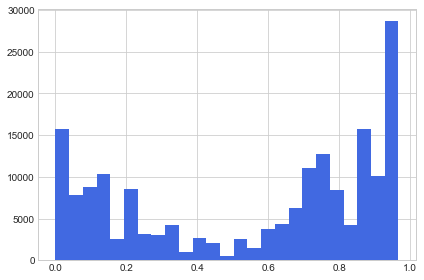

In [168]:
zip_predicts.avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

In [169]:
zip_num_claims = pd.DataFrame(zip_predicts.zip_code.value_counts())

In [170]:
zip_num_claims.rename(columns={'zip_code':'zip_code_count'}, inplace=True)

In [171]:
zip_num_claims.sort_index(inplace=True)

In [172]:
zip_predict_avg = zip_predicts.drop_duplicates(subset='zip_code', keep='first')

In [173]:
zip_predict_avg.drop(columns='likely_flooded',inplace=True)

In [174]:
zip_predict_avg.set_index('zip_code', inplace=True)

In [175]:
zip_predict_avg.sort_index(inplace=True)

In [176]:
zip_predict_avg = zip_predict_avg.join(zip_num_claims)

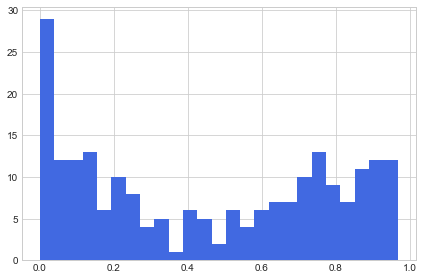

In [177]:
zip_predict_avg.avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

In [178]:
zip_predict_avg[zip_predict_avg.avg_flooding>=0.5].shape

(104, 2)

In [179]:
zip_predict_avg[zip_predict_avg.avg_flooding<0.5].shape

(113, 2)

In [180]:
view(zip_predict_avg,5)

,avg_flooding,zip_code_count
zip_code,,
77002,0.000000,75
77003,0.000000,164
77004,0.000000,685
77005,0.130952,420
77006,0.039326,178
...,...,...
77598,0.647619,315
77665,0.890947,486
78933,0.000000,6


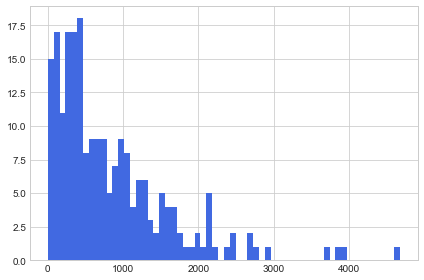

In [181]:
zip_predict_avg.zip_code_count.hist(bins=60, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

In [182]:
zip_predict_avg.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,217.0,0.450126,0.335534,0.0,0.124023,0.450199,0.763636,0.967057
zip_code_count,217.0,829.820276,779.656240,3.0,290.000000,594.000000,1164.000000,4673.000000


In [183]:
zip_predict_avg[zip_predict_avg.zip_code_count<100].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,19.0,0.303036,0.312486,0.0,0.0,0.244681,0.524291,0.893617
zip_code_count,19.0,50.894737,32.768370,3.0,20.5,52.000000,78.500000,94.000000


In [184]:
zip_predict_avg[zip_predict_avg.avg_flooding==0].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,24.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
zip_code_count,24.0,560.916667,554.013492,3.0,142.75,405.5,762.25,2193.0


In [185]:
zip_predict_avg[zip_predict_avg.avg_flooding>=0.5].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,104.0,0.769809,0.126497,0.516667,0.683267,0.770561,0.883318,0.967057
zip_code_count,104.0,1051.826923,921.045601,9.000000,388.750000,797.500000,1489.000000,4673.000000


In [186]:
zip_predict_avg[zip_predict_avg.zip_code_count>500].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,116.0,0.520437,0.349084,0.0,0.132508,0.651677,0.853994,0.967057
zip_code_count,116.0,1330.327586,761.679606,502.0,789.750000,1091.500000,1603.500000,4673.000000


In [187]:
zip_predict_avg[zip_predict_avg.avg_flooding>=0.5][zip_predict_avg.zip_code_count>500].shape

(66, 2)

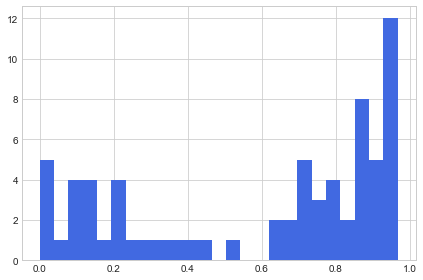

In [188]:
zip_predict_avg[zip_predict_avg.zip_code_count>=1000].avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

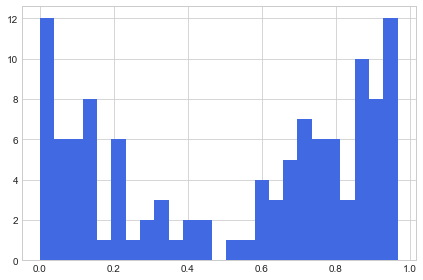

In [189]:
zip_predict_avg[zip_predict_avg.zip_code_count>=500].avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

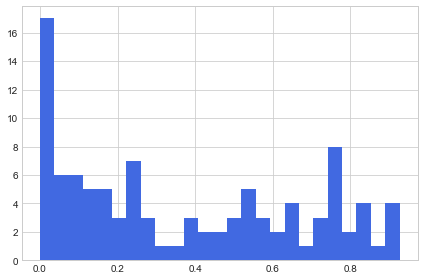

In [190]:
zip_predict_avg[zip_predict_avg.zip_code_count<500].avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()
plt.show()

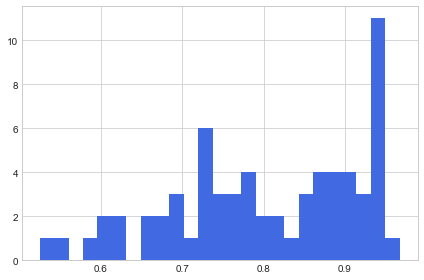

In [191]:
zip_predict_avg[zip_predict_avg.avg_flooding>=0.5][zip_predict_avg.zip_code_count>=500].avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

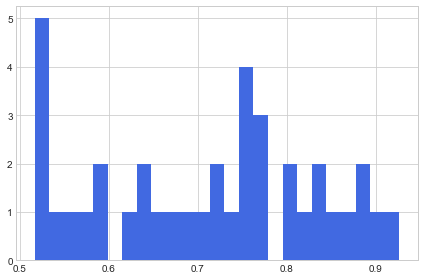

In [192]:
zip_predict_avg[zip_predict_avg.avg_flooding>=0.5][zip_predict_avg.zip_code_count<500].avg_flooding.hist(bins=25, figsize=(6,4), color='royalblue')
plt.tight_layout()
plt.show()

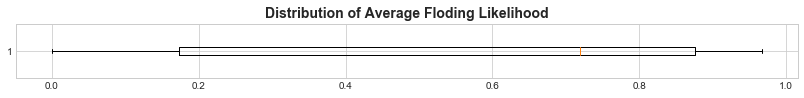

In [193]:
plt.figure(figsize=(14,1))
plt.boxplot(zip_predicts.avg_flooding, showfliers=True, vert=False)
plt.title('Distribution of Average Floding Likelihood', fontsize=14, fontweight='bold')
plt.show()

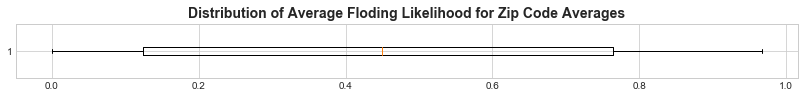

In [194]:
plt.figure(figsize=(14,1))
plt.boxplot(zip_predict_avg.avg_flooding, showfliers=True, vert=False)
plt.title('Distribution of Average Floding Likelihood for Zip Code Averages', fontsize=14, fontweight='bold')
plt.show()

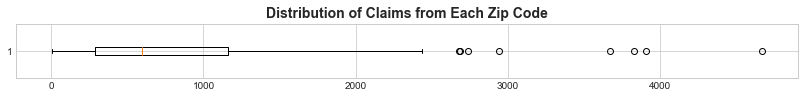

In [195]:
plt.figure(figsize=(14,1))
plt.boxplot(zip_predict_avg.zip_code_count, showfliers=True, vert=False)
plt.title('Distribution of Claims from Each Zip Code', fontsize=14, fontweight='bold')
plt.show()

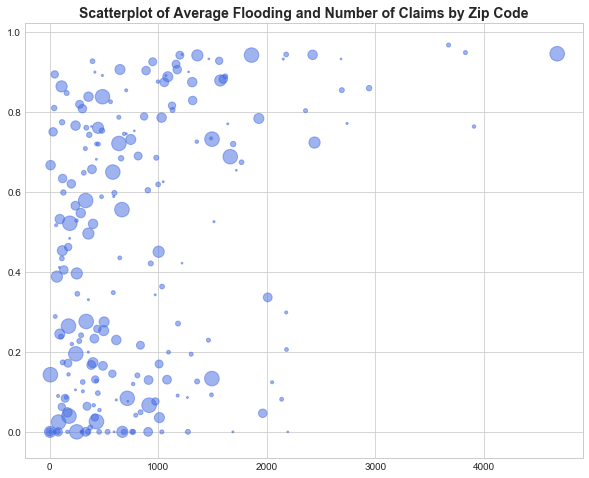

In [196]:
area = (15 * np.random.rand(20))**2

plt.figure(figsize=(10,8))
plt.scatter(zip_predict_avg.zip_code_count, zip_predict_avg.avg_flooding, color='royalblue', s=area, alpha=0.5)
plt.title('Scatterplot of Average Flooding and Number of Claims by Zip Code', fontsize=14, fontweight='bold')
plt.show()

In [197]:
zip_predict_avg[zip_predict_avg.zip_code_count>=100][zip_predict_avg.avg_flooding>=.5].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_flooding,98.0,0.774406,0.124249,0.52,0.68598,0.772457,0.886351,0.967057
zip_code_count,98.0,1113.326531,913.522149,110.00,430.50000,896.000000,1508.500000,4673.000000


In [198]:
zip_predict_avg['flood_prone_area'] = False

In [199]:
zip_predict_avg.loc[(zip_predict_avg.zip_code_count>=100) & (zip_predict_avg.avg_flooding>=.5), 'flood_prone_area'] = True

In [200]:
zip_predict_avg

,avg_flooding,zip_code_count,flood_prone_area
zip_code,,,
77002,0.000000,75,False
77003,0.000000,164,False
77004,0.000000,685,False
77005,0.130952,420,False
77006,0.039326,178,False
77007,0.127610,431,False
77008,0.348123,586,False
77009,0.076389,720,False
77010,0.000000,3,False


In [201]:
zip_predict_avg.flood_prone_area.value_counts()

False    119
True      98
Name: flood_prone_area, dtype: int64

In [202]:
zip_predict_avg = zip_predict_avg.drop(columns=['avg_flooding','zip_code_count'])

In [203]:
zip_predict_avg.reset_index(inplace=True)

In [204]:
zip_predict_avg.zip_code = zip_predict_avg.zip_code.astype('int')

## Add Flood Likelihood Prediction to MLS

In [205]:
mls = pd.read_csv('har_explored_cleaned.csv', index_col=0)

In [206]:
view(mls,1)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed
3,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371325,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68


In [207]:
df = pd.merge(mls,zip_predict_avg[['zip_code','flood_prone_area']], on='zip_code', how='left')

In [208]:
df.flood_prone_area.fillna(False, inplace=True)

In [209]:
view(df,3)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed,flood_prone_area
0,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65,True
1,86143414,Townhouse/Condo,Sold,Galveston,77554,Galveston,25000,33,22 - Galveston,BALL HIGH SCHOOL,801.0,2242.8,1984,1.0,1.0,0.0,2.0,0,0,49.0,49,2017-07-07,1,1,35,33,False
2,99874455,Townhouse/Condo,Sold,Montgomery,77356,Montgomery,36000,39,37 - Montgomery,MONTGOMERY HIGH SCHOOL,489.0,1956.0,1979,1.0,1.0,0.0,1.0,0,0,86.0,86,2017-06-02,0,0,40,38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301002,43582225,Single-Family,Withdrawn,Houston,77007,Harris,998000,9,27 - Houston,HEIGHTS HIGH SCHOOL,3724.0,3010.0,2018,4.0,3.0,1.0,3.0,0,0,61.0,61,2018-12-24,1,1,1,0,False
301003,53833919,Single-Family,Withdrawn,Houston,77025,Harris,999000,17,27 - Houston,LAMAR HIGH SCHOOL (HOUSTON),4299.0,9167.0,2005,4.0,3.0,1.0,2.0,0,0,111.0,319,2018-03-28,1,1,14,13,True
301004,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68,True


## Exporting DataFrame

In [210]:
df.to_csv('mls_with_flood_likelihood.csv')

## Conclusion

The best performing model was the XGBoost model after removing the low-ranking features from the initial XGBoost model. This gave us a predictive accuracy of 71.33% in assessing the likelihood that a FEMA claim was confirmed to have flood damage.

The results showed that the biggest predictive features contributing to this were average number of stories, average list price, average home age in each zip code. In terms of locations, Fort Bend South was significant in that 81% of the claims filed there did not actually have any flood damage.

Using my highest performing model, I filtered them through a system that eliminated zip codes that had fewer than 100 filed claims and a result of fewer than 50% confirmed cases of flooding per zip code.

### Community Action Items

* Educate politicians on flooding, get them flood-literate
* Focus on current Houston, not just expanding development
* As a community - clean gutters and drains in local neighborhoods

### Future Work

* Assign a more meaningful description indicating flood risk, such as a scale
* Reduce spatial range in averaged data from zip codes to census tracts by reverse geocoding MLS addresses
* Use county appraisal data to get information on all Greater Houston homes, not just those on HAR
* Find current flood risk by flood plain maps to use as base flood likelihood
* Remove rows for zip codes that had very few occurrences in FEMA, before binning
* Make more zip code bins (fewer per bin)
* Work with data of flood impact beyond Hurricane Harvey
* Limitation: the claims in this dataset may not be inclusive of all homes that experienced flood damage during Hurricane Harvey